In [1]:
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import RandomizedSearchCV

In [2]:
pd.set_option('display.max_rows', None)

In [3]:
from sklearn.neural_network import MLPClassifier

param_dist_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh', 'logistic'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01],
    'solver': ['adam'],
    'max_iter': [200, 300]
}


In [4]:
import os
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)
from sklearn.preprocessing import label_binarize


def train_phase(phase_path, n_iter=10, random_state=42, sample=False):
    best_model = None
    best_score = 0
    all_metrics = []
    best_params = None

    for fold in range(1, 6):
        fold_path = os.path.join(phase_path, f"fold{fold}")
        scaler = joblib.load(f"{fold_path}/scaler.pkl")

        if sample:
            X_train = pd.read_csv(f"{fold_path}/X_train_resampled.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train_resampled.csv").values.ravel()
            X_train_scaled = X_train
        else:
            X_train = pd.read_csv(f"{fold_path}/X_train.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train.csv").values.ravel()
            X_train_scaled = scaler.transform(X_train)
            X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

        X_val = pd.read_csv(f"{fold_path}/X_val.csv")
        y_val = pd.read_csv(f"{fold_path}/y_val.csv").values.ravel()
        X_val_scaled = scaler.transform(X_val)
        X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_train.columns)

        if fold == 1:
            clf = MLPClassifier(random_state=random_state)
            search = RandomizedSearchCV(
                clf,
                param_distributions=param_dist_mlp,
                n_iter=n_iter,
                cv=3,
                n_jobs=-1,
                verbose=1,
                scoring='f1_macro'
            )
            search.fit(X_train_scaled, y_train)
            best_params = search.best_params_
            print(f"[Fold 1] Best Parameters Found: {best_params}")

        model = MLPClassifier(**best_params, random_state=random_state)
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_val_scaled)
        y_proba = model.predict_proba(X_val_scaled)

        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average='macro')

        classes = model.classes_
        y_val_bin = label_binarize(y_val, classes=classes)
        auc = roc_auc_score(y_val_bin, y_proba, average='macro', multi_class='ovr')

        all_metrics.append({'fold': fold, 'accuracy': acc, 'f1_macro': f1, 'auc': auc})

        if f1 > best_score:
            best_score = f1
            best_model = model
            best_scaler = scaler
            best_fold = fold

        print(f"\nFold {fold} Classification Report:\n", classification_report(y_val, y_pred))

        cm = confusion_matrix(y_val, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=classes, yticklabels=classes)
        plt.title(f'Confusion Matrix - Fold {fold}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8, 6))
        for i, cls in enumerate(classes):
            fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_proba[:, i])
            plt.plot(fpr, tpr, label=f'Class {cls}')
        plt.plot([0, 1], [0, 1], 'k--', label='Chance')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - Fold {fold}')
        plt.legend()
        plt.tight_layout()
        plt.show()

    avg_metrics = pd.DataFrame(all_metrics).mean().to_dict()
    print(f"\nAverage Accuracy: {avg_metrics['accuracy']:.4f}")
    print(f"Average F1 Macro: {avg_metrics['f1_macro']:.4f}")
    print(f"Average AUC: {avg_metrics['auc']:.4f}")

    return best_model, best_scaler, best_fold, all_metrics




======= Training Phase 1 ========

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[Fold 1] Best Parameters Found: {'solver': 'adam', 'max_iter': 300, 'learning_rate_init': 0.01, 'hidden_layer_sizes': (50,), 'alpha': 0.001, 'activation': 'relu'}

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.93      0.83      1785
           1       0.67      0.24      0.35       604
           2       0.43      0.36      0.39       258
           3       0.34      0.32      0.33        59
           4       0.50      0.11      0.18         9

    accuracy                           0.71      2715
   macro avg       0.54      0.39      0.42      2715
weighted avg       0.69      0.71      0.67      2715



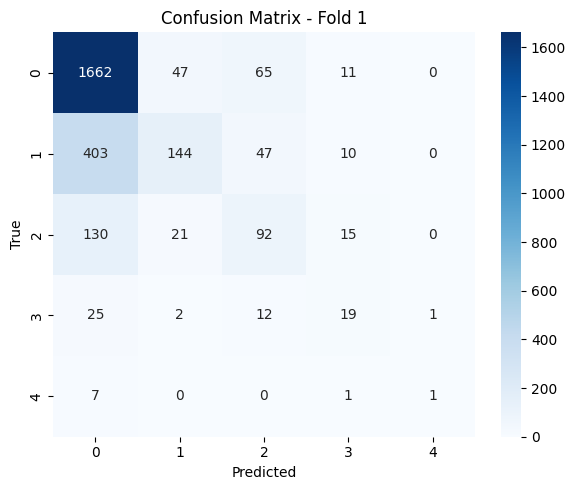

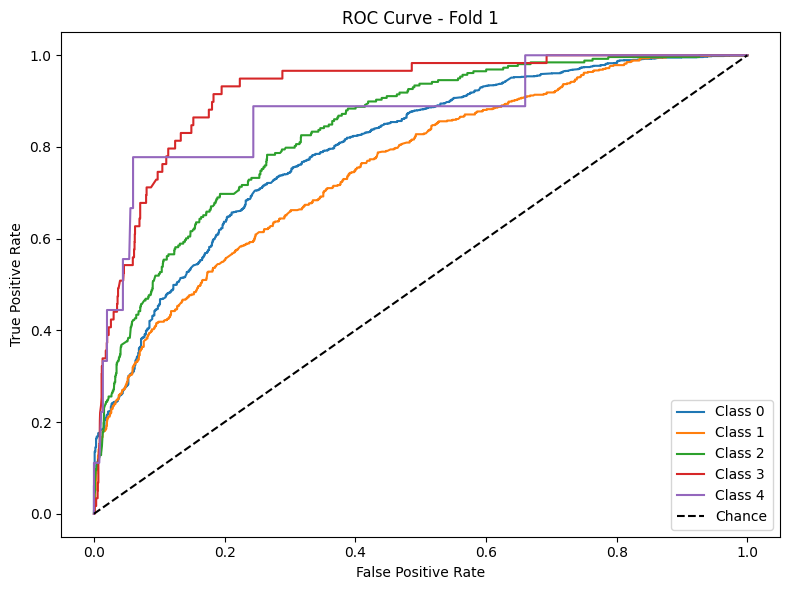


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.89      0.82      1786
           1       0.54      0.38      0.45       603
           2       0.47      0.29      0.36       258
           3       0.36      0.25      0.30        59
           4       0.33      0.12      0.18         8

    accuracy                           0.70      2714
   macro avg       0.49      0.39      0.42      2714
weighted avg       0.68      0.70      0.68      2714



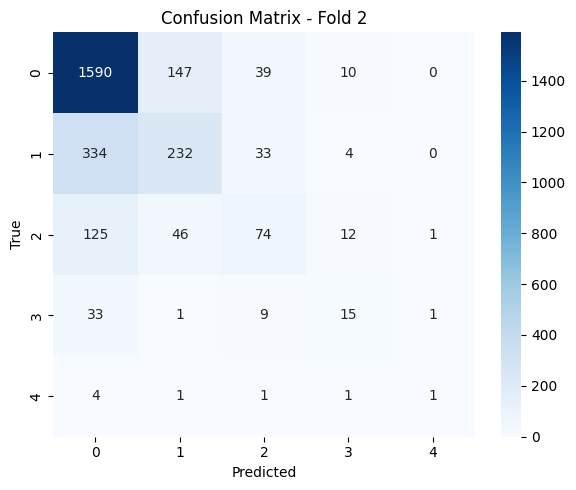

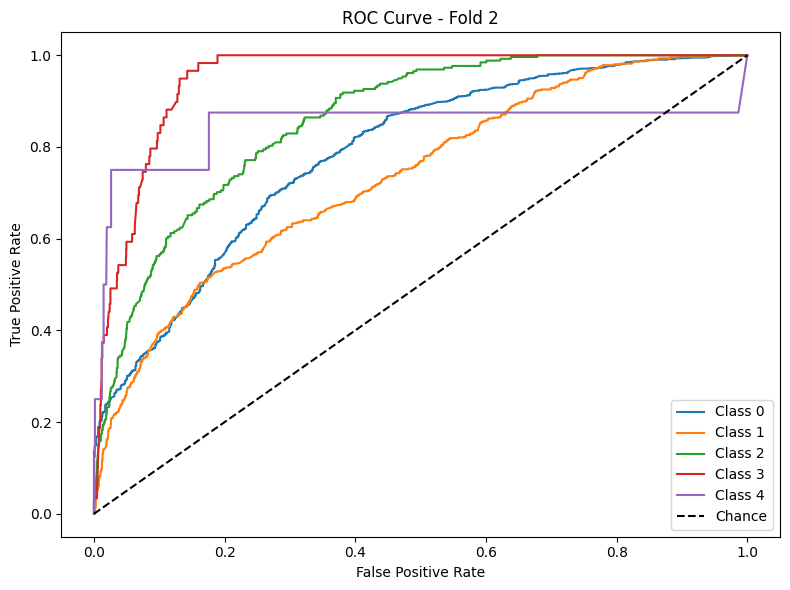


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.88      0.82      1786
           1       0.53      0.35      0.42       603
           2       0.39      0.36      0.37       258
           3       0.40      0.17      0.24        59
           4       0.33      0.12      0.18         8

    accuracy                           0.69      2714
   macro avg       0.48      0.38      0.41      2714
weighted avg       0.67      0.69      0.67      2714



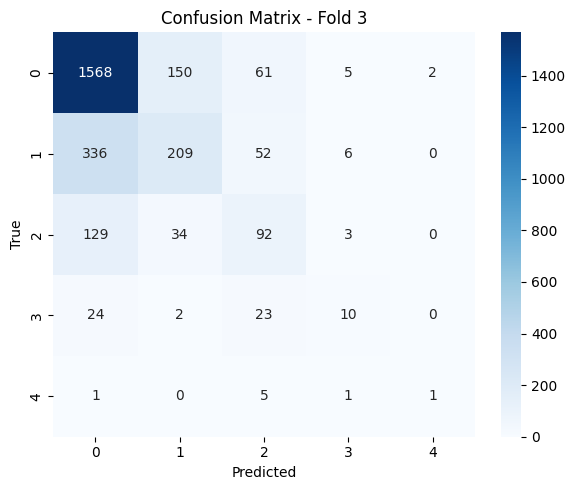

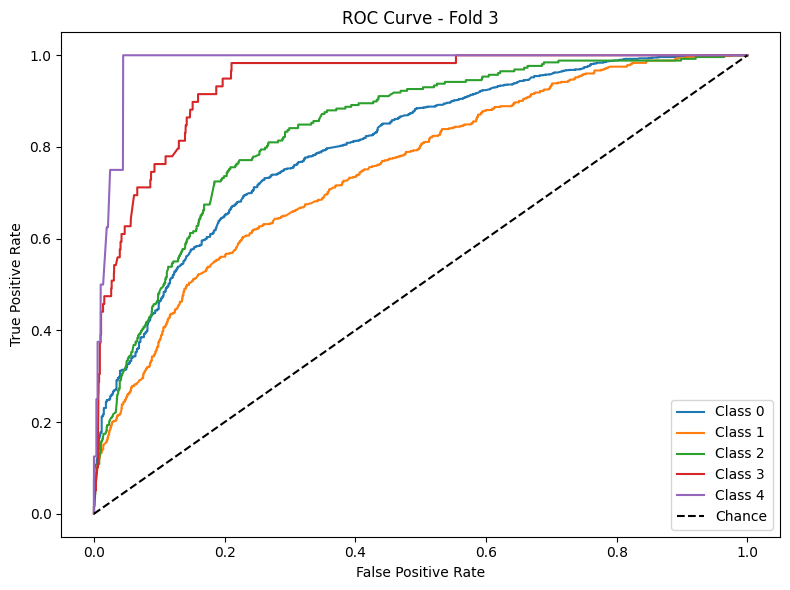


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.88      0.81      1785
           1       0.51      0.38      0.43       603
           2       0.53      0.22      0.32       258
           3       0.34      0.31      0.32        59
           4       1.00      0.11      0.20         9

    accuracy                           0.69      2714
   macro avg       0.63      0.38      0.42      2714
weighted avg       0.66      0.69      0.66      2714



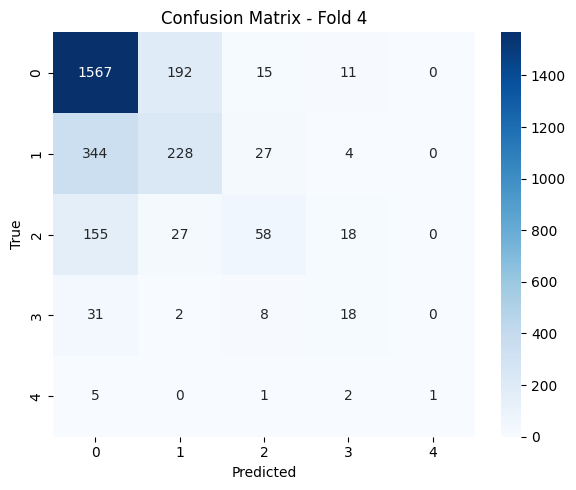

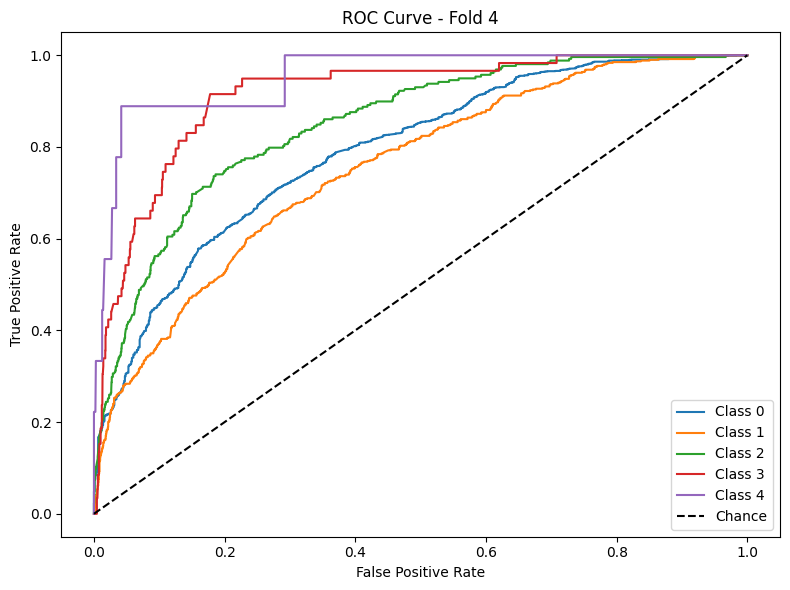


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.94      0.83      1785
           1       0.64      0.29      0.40       603
           2       0.52      0.29      0.37       258
           3       0.29      0.20      0.24        59
           4       0.50      0.11      0.18         9

    accuracy                           0.71      2714
   macro avg       0.54      0.37      0.40      2714
weighted avg       0.69      0.71      0.67      2714



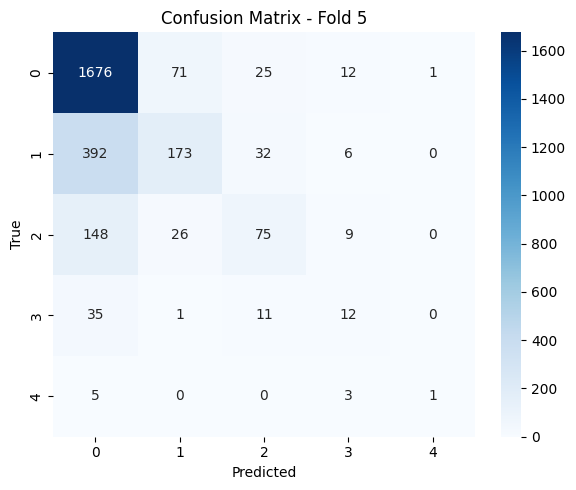

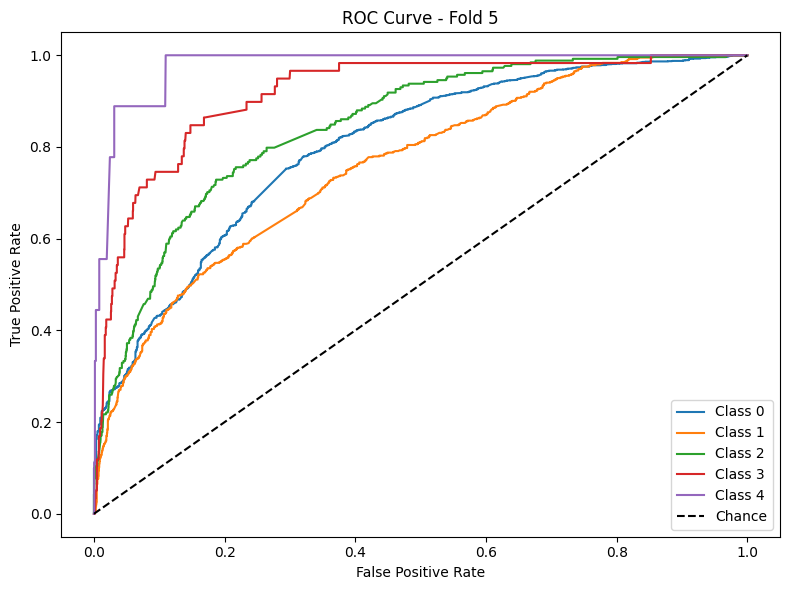


Average Accuracy: 0.7014
Average F1 Macro: 0.4126
Average AUC: 0.8490


======= Training Phase 2 ========

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

[Fold 1] Best Parameters Found: {'solver': 'adam', 'max_iter': 300, 'learning_rate_init': 0.001, 'hidden_layer_sizes': (100, 50), 'alpha': 0.001, 'activation': 'relu'}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.94      0.82      1489
           1       0.61      0.22      0.32       488
           2       0.44      0.25      0.31       220
           3       0.43      0.37      0.40        54
           4       0.00      0.00      0.00         9

    accuracy                           0.70      2260
   macro avg       0.44      0.36      0.37      2260
weighted avg       0.67      0.70      0.65      2260



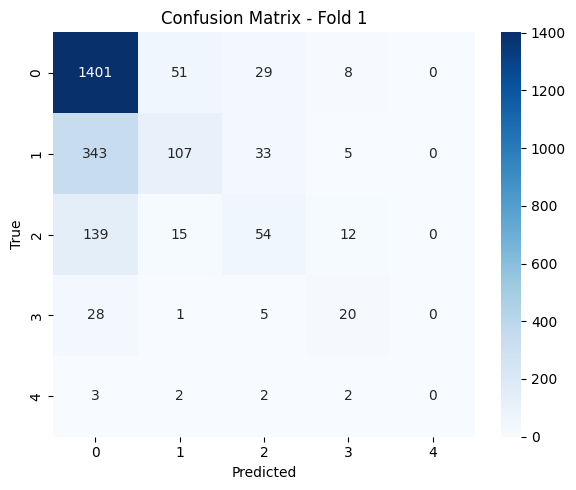

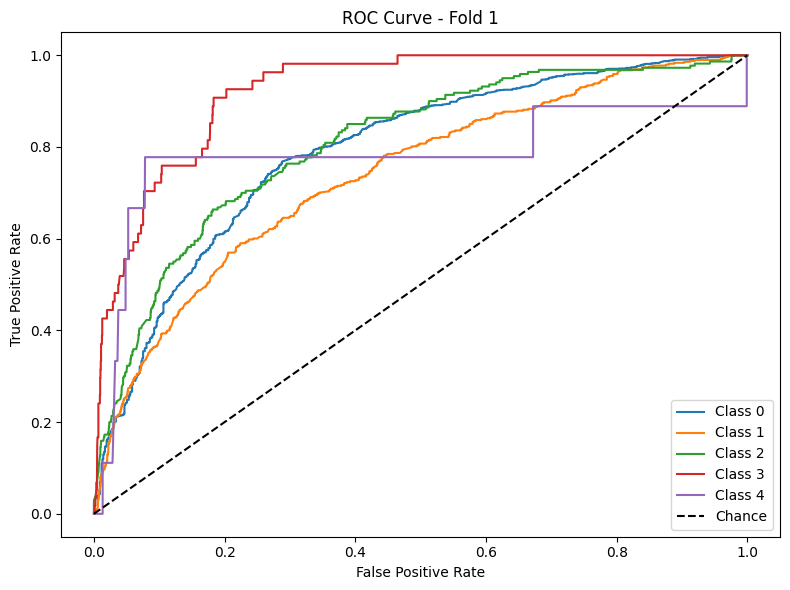

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.95      0.83      1489
           1       0.62      0.25      0.36       489
           2       0.50      0.33      0.40       219
           3       0.25      0.02      0.03        55
           4       0.00      0.00      0.00         8

    accuracy                           0.71      2260
   macro avg       0.42      0.31      0.32      2260
weighted avg       0.67      0.71      0.66      2260



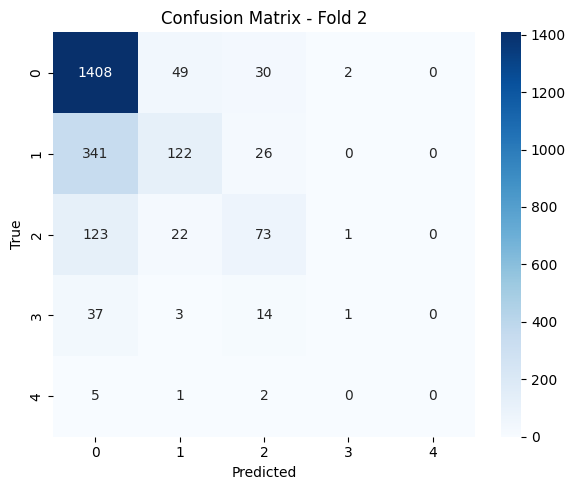

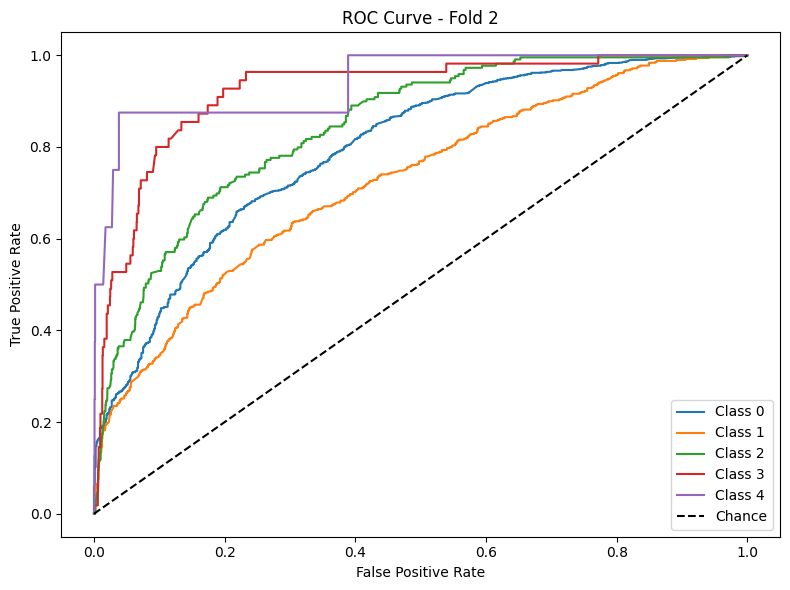


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.93      0.83      1489
           1       0.51      0.25      0.33       489
           2       0.42      0.24      0.30       219
           3       0.29      0.28      0.29        54
           4       0.00      0.00      0.00         8

    accuracy                           0.69      2259
   macro avg       0.39      0.34      0.35      2259
weighted avg       0.65      0.69      0.65      2259



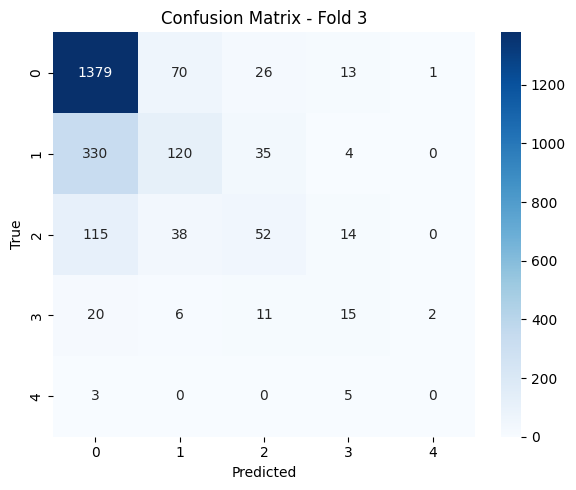

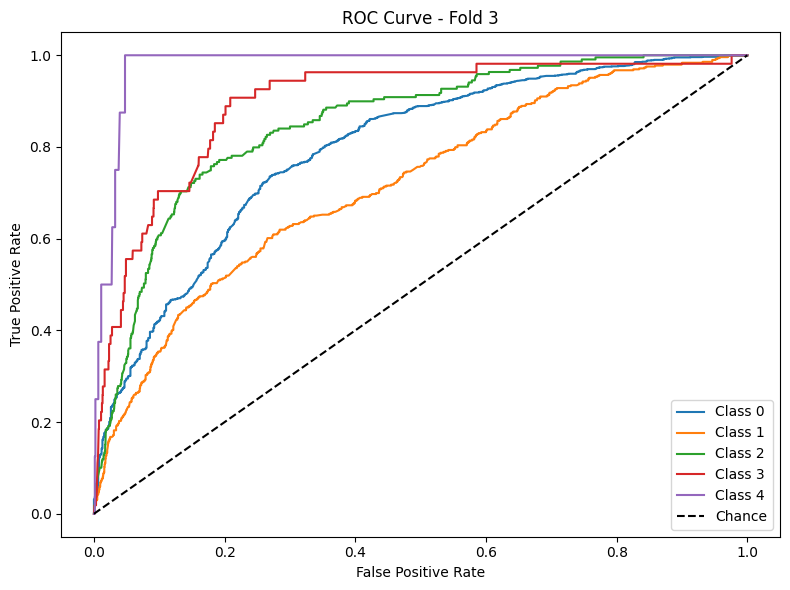


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.89      0.81      1489
           1       0.54      0.28      0.37       489
           2       0.44      0.39      0.42       219
           3       0.39      0.28      0.33        54
           4       0.50      0.12      0.20         8

    accuracy                           0.69      2259
   macro avg       0.53      0.39      0.43      2259
weighted avg       0.67      0.69      0.67      2259



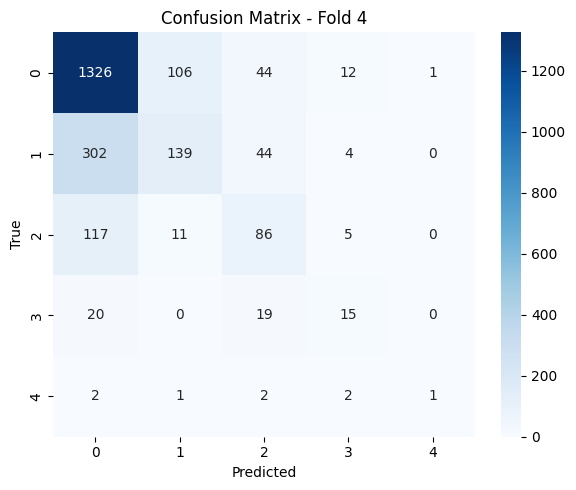

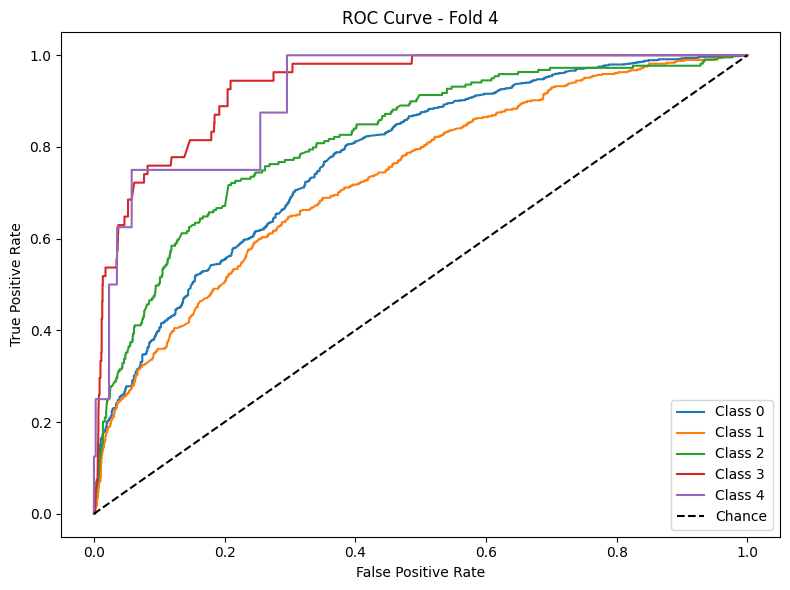


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.93      0.83      1490
           1       0.53      0.24      0.33       488
           2       0.43      0.32      0.37       219
           3       0.22      0.13      0.16        54
           4       0.00      0.00      0.00         8

    accuracy                           0.69      2259
   macro avg       0.39      0.32      0.34      2259
weighted avg       0.65      0.69      0.65      2259



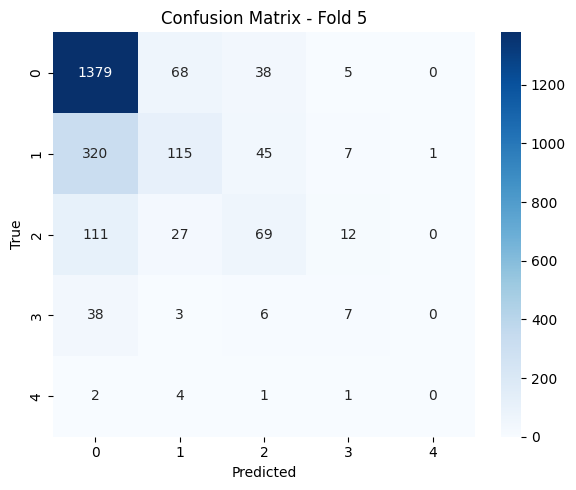

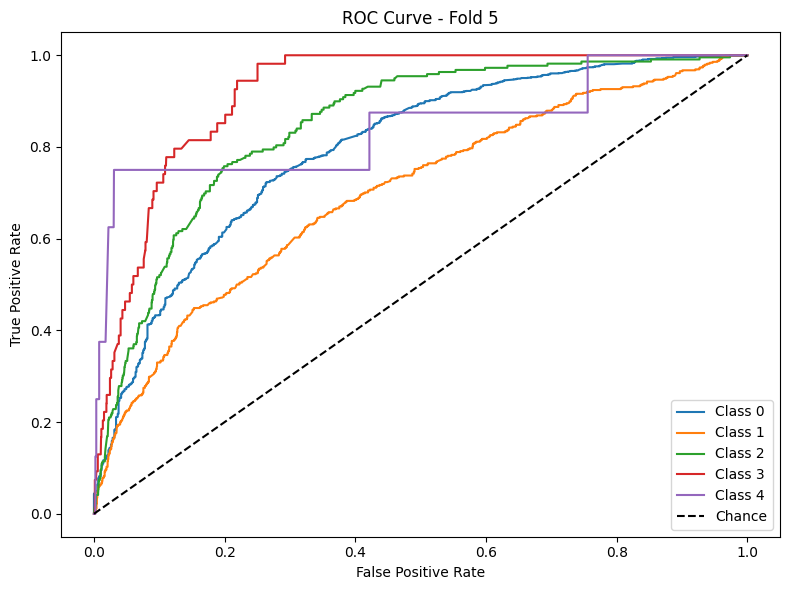


Average Accuracy: 0.6983
Average F1 Macro: 0.3612
Average AUC: 0.8313


======= Training Phase 3 ========

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

[Fold 1] Best Parameters Found: {'solver': 'adam', 'max_iter': 200, 'learning_rate_init': 0.001, 'hidden_layer_sizes': (100, 50), 'alpha': 0.001, 'activation': 'tanh'}

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.90      0.83      1361
           1       0.49      0.25      0.34       459
           2       0.44      0.36      0.40       198
           3       0.26      0.37      0.31        49
           4       0.00      0.00      0.00         7

    accuracy                           0.69      2074
   macro avg       0.39      0.38      0.37      2074
weighted avg       0.66      0.69      0.66      2074



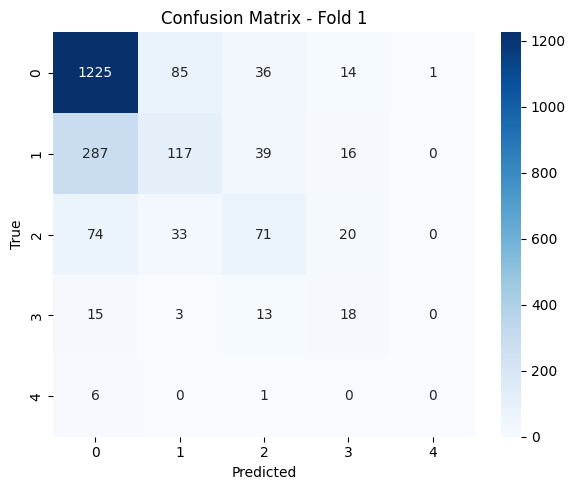

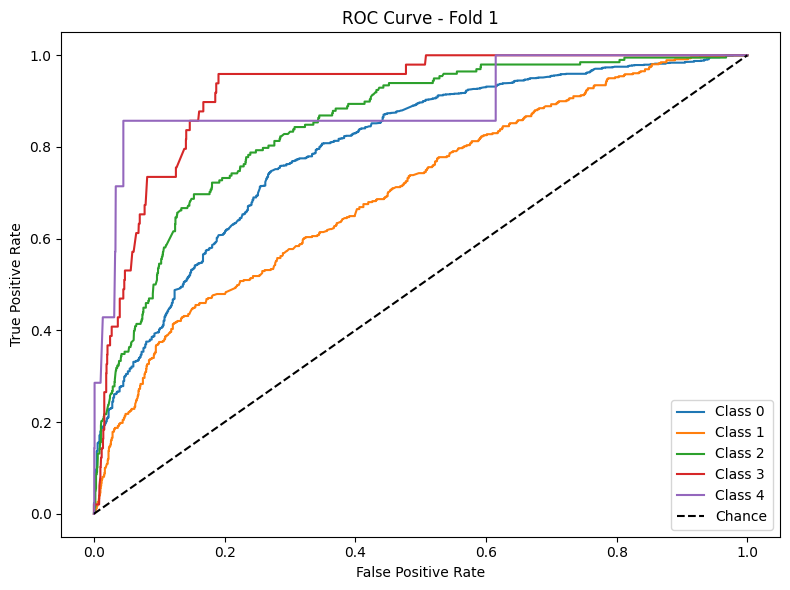


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.88      0.82      1360
           1       0.47      0.32      0.38       459
           2       0.43      0.34      0.38       198
           3       0.40      0.40      0.40        50
           4       0.00      0.00      0.00         7

    accuracy                           0.69      2074
   macro avg       0.41      0.39      0.40      2074
weighted avg       0.66      0.69      0.67      2074



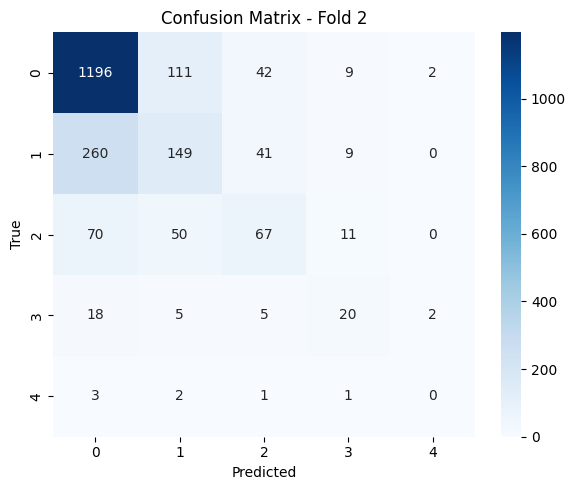

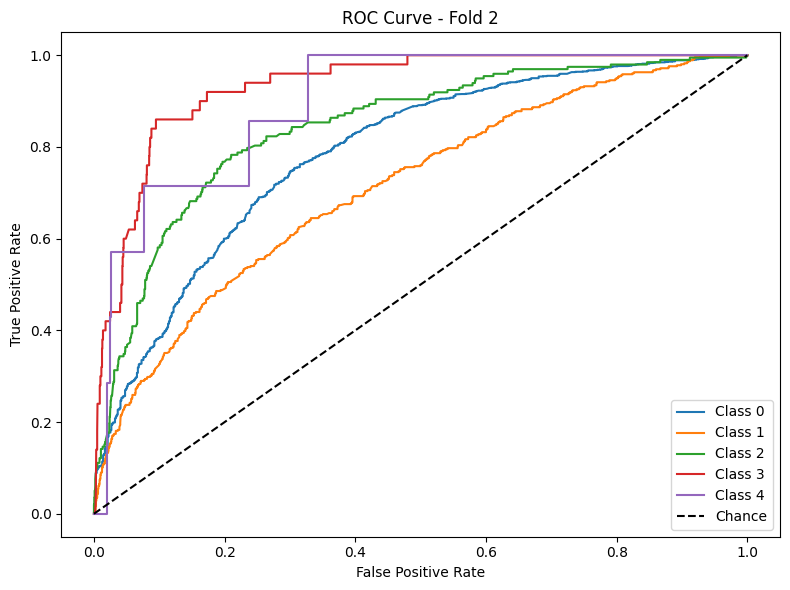

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.88      0.82      1360
           1       0.48      0.28      0.35       459
           2       0.41      0.46      0.43       198
           3       0.32      0.24      0.28        50
           4       0.00      0.00      0.00         7

    accuracy                           0.69      2074
   macro avg       0.40      0.37      0.38      2074
weighted avg       0.66      0.69      0.66      2074



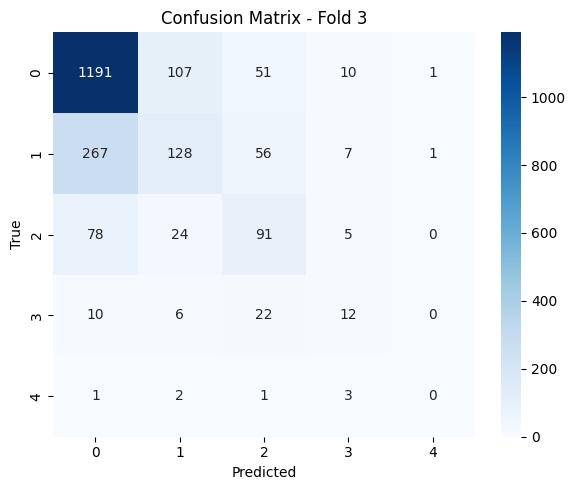

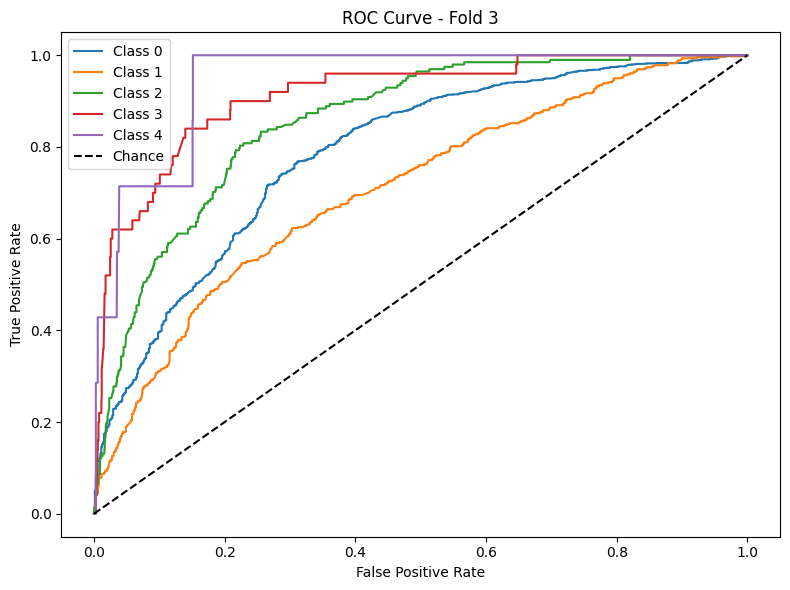

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.90      0.81      1360
           1       0.45      0.24      0.31       459
           2       0.48      0.33      0.39       198
           3       0.52      0.32      0.40        50
           4       0.00      0.00      0.00         7

    accuracy                           0.68      2074
   macro avg       0.44      0.36      0.38      2074
weighted avg       0.64      0.68      0.65      2074



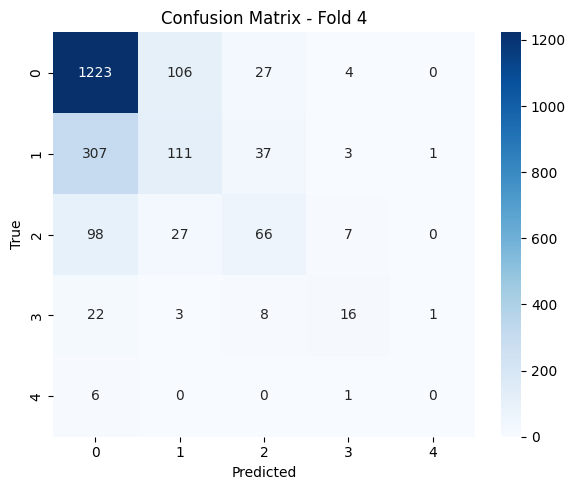

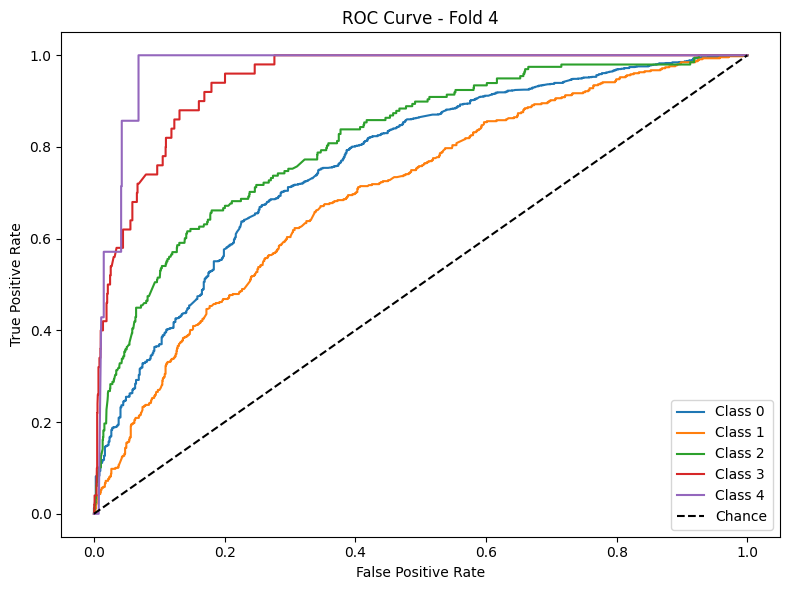

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.88      0.81      1360
           1       0.44      0.27      0.33       460
           2       0.44      0.34      0.38       197
           3       0.35      0.35      0.35        49
           4       0.20      0.14      0.17         7

    accuracy                           0.68      2073
   macro avg       0.44      0.40      0.41      2073
weighted avg       0.64      0.68      0.65      2073



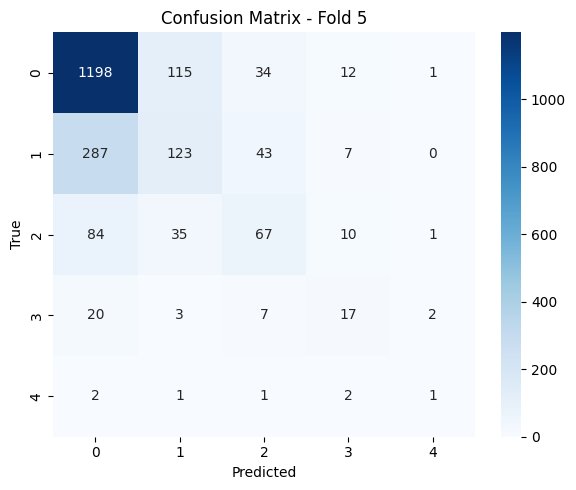

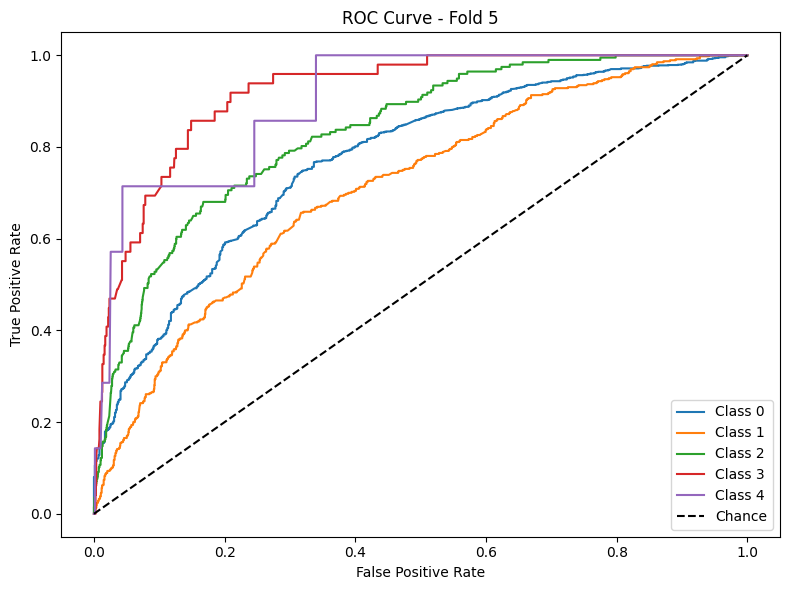


Average Accuracy: 0.6854
Average F1 Macro: 0.3877
Average AUC: 0.8353


======= Training Phase 4 ========

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

[Fold 1] Best Parameters Found: {'solver': 'adam', 'max_iter': 300, 'learning_rate_init': 0.001, 'hidden_layer_sizes': (100,), 'alpha': 0.01, 'activation': 'logistic'}


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and 


Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.89      0.82      1000
           1       0.57      0.39      0.46       355
           2       0.44      0.29      0.35       139
           3       0.36      0.44      0.40        39
           4       0.00      0.00      0.00         6

    accuracy                           0.70      1539
   macro avg       0.43      0.40      0.41      1539
weighted avg       0.68      0.70      0.68      1539



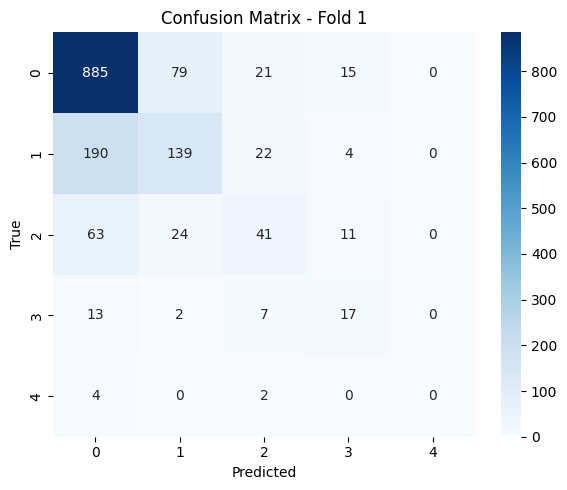

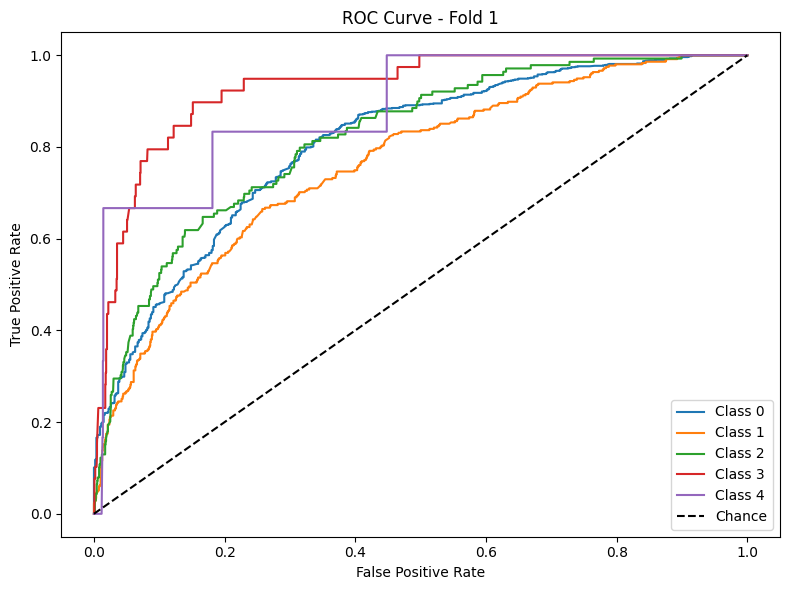

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and 


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.92      0.83      1000
           1       0.57      0.32      0.41       355
           2       0.52      0.37      0.44       139
           3       0.46      0.42      0.44        40
           4       0.00      0.00      0.00         5

    accuracy                           0.71      1539
   macro avg       0.46      0.41      0.42      1539
weighted avg       0.69      0.71      0.69      1539



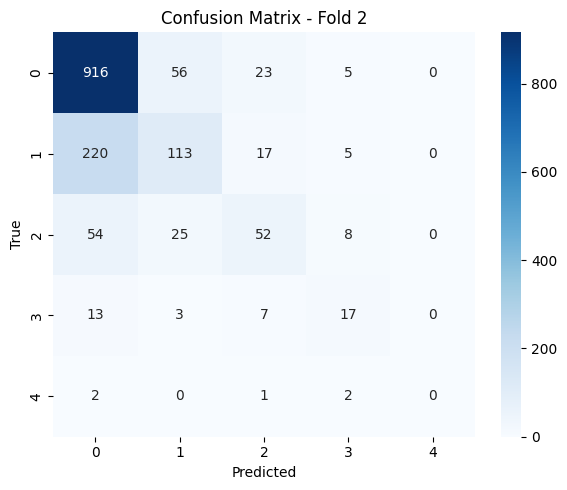

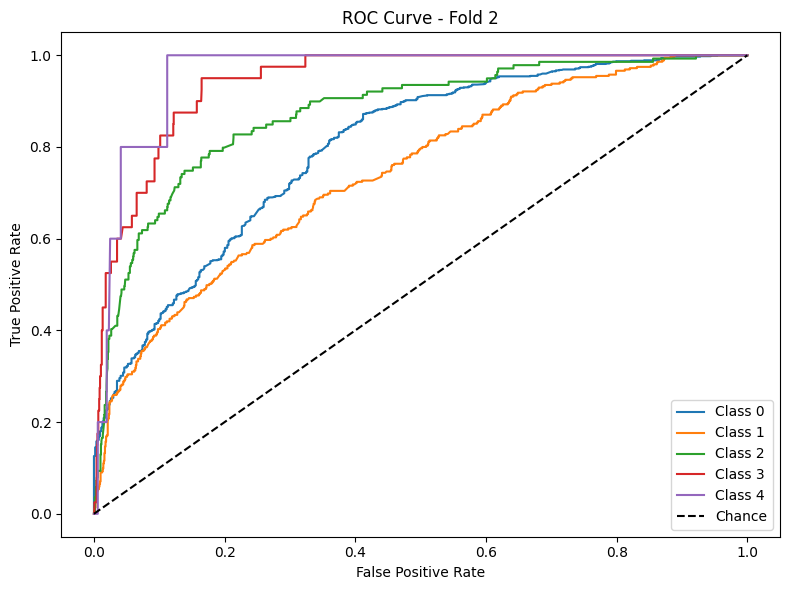

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(



Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.91      0.83       999
           1       0.57      0.37      0.45       355
           2       0.57      0.33      0.42       139
           3       0.38      0.40      0.39        40
           4       1.00      0.17      0.29         6

    accuracy                           0.72      1539
   macro avg       0.66      0.44      0.47      1539
weighted avg       0.69      0.72      0.69      1539



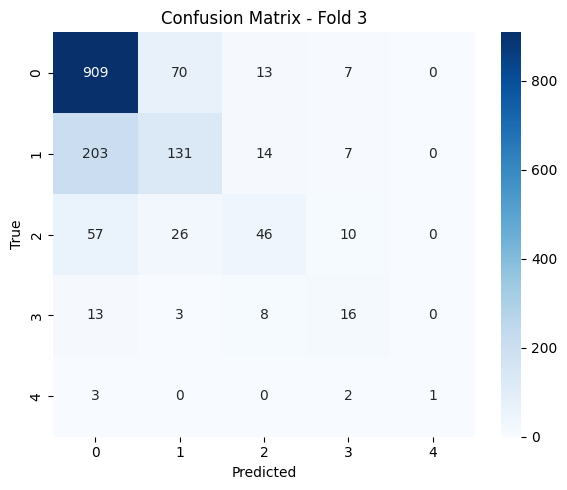

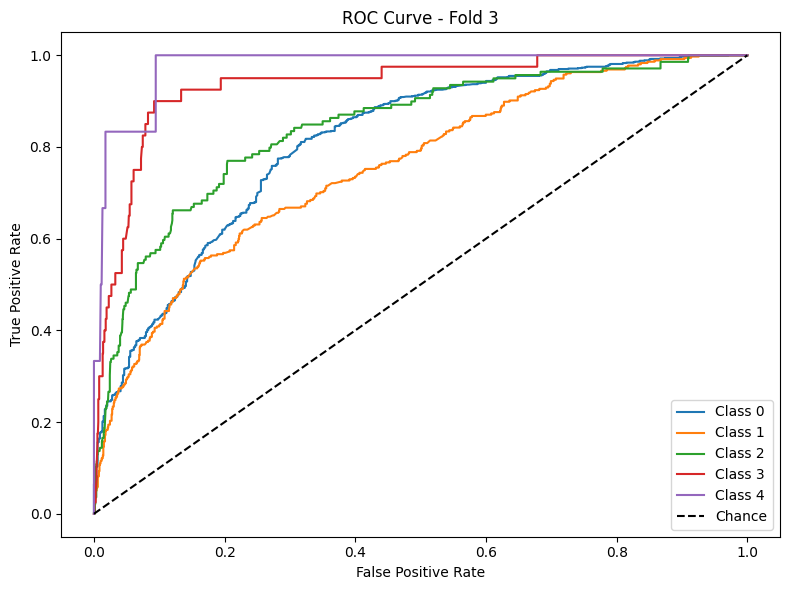

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and 


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.92      0.84       999
           1       0.61      0.37      0.46       356
           2       0.46      0.35      0.40       138
           3       0.32      0.36      0.34        39
           4       0.00      0.00      0.00         6

    accuracy                           0.72      1538
   macro avg       0.43      0.40      0.41      1538
weighted avg       0.70      0.72      0.70      1538



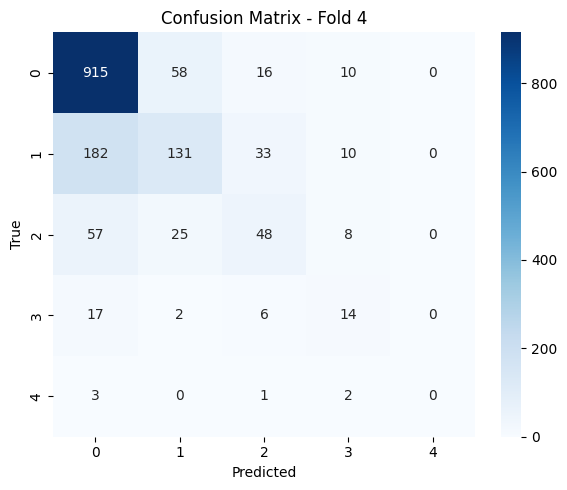

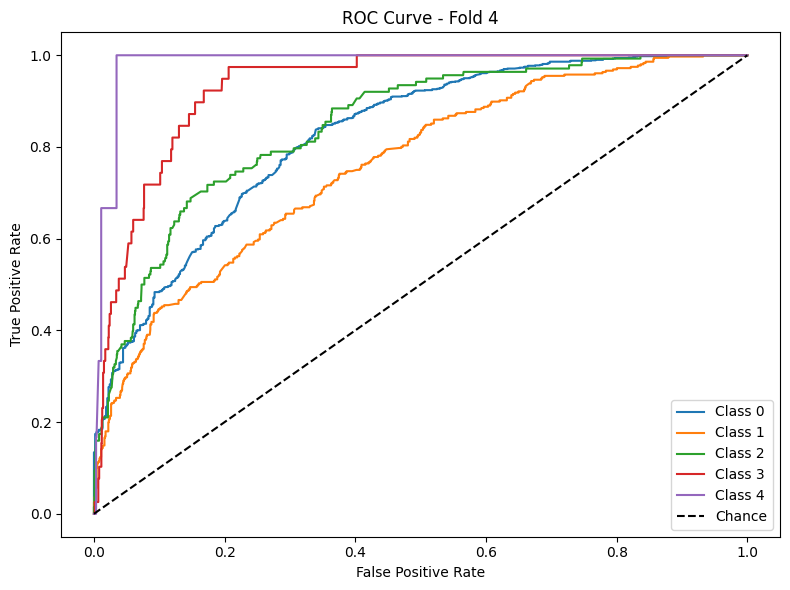

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(



Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.87      0.82       999
           1       0.55      0.40      0.46       356
           2       0.41      0.33      0.37       138
           3       0.47      0.49      0.48        39
           4       1.00      0.17      0.29         6

    accuracy                           0.70      1538
   macro avg       0.64      0.45      0.48      1538
weighted avg       0.68      0.70      0.69      1538



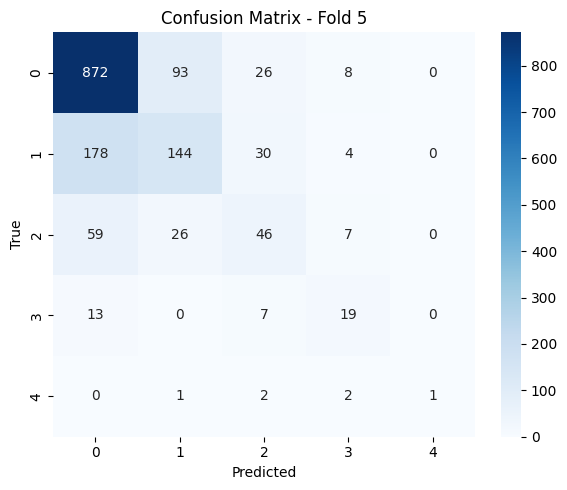

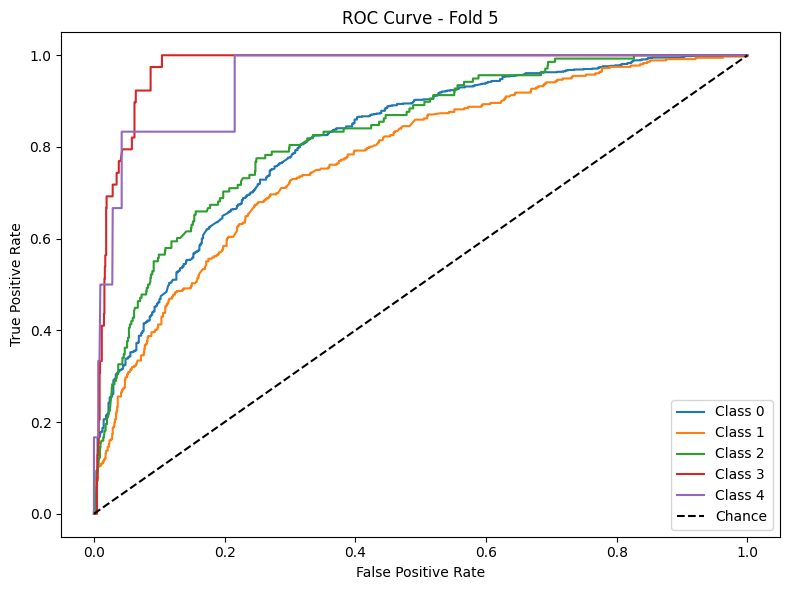


Average Accuracy: 0.7114
Average F1 Macro: 0.4393
Average AUC: 0.8612


In [5]:
phase_paths = [f"/kaggle/input/smotesvm-train-enrich-data/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n===================================")
    print(f"\n======= Training Phase {i} ========")
    print(f"\n===================================")
    sample = False
    model, scaler, best_fold, metrics = train_phase(phase_path, sample = sample)
    # Save best model & scaler
    if sample: 
        temp = "sample"
    else: temp = "no_sample"
    joblib.dump(model, f"best_model_{temp}_phase{i}.pkl")
    joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")
    results[f"phase{i}"] = metrics


## Predict on Test Data

In [6]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

def predict_on_test(test_file_path, model_file, scaler_file, school_mapping_file):
    # Load model, scaler, and mapping
    model = joblib.load(model_file)
    scaler = joblib.load(scaler_file)
    mapping = joblib.load(school_mapping_file)

    # Load and preprocess test data
    df_test = pd.read_csv(test_file_path)
    y_test = df_test['label_encoded']
    X_test = df_test.drop(columns=['user_id', 'course_id', 'label_encoded', 'label', 'total_score'], axis=1)

    # Apply school mapping
    if 'school' in X_test.columns:
        X_test['school'] = X_test['school'].map(mapping).fillna(0).astype(int)

    # Scale features
    X_test_scaled = scaler.transform(X_test)

    # Predict
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)

    # Classification Report
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # AUC Score
    classes = model.classes_
    y_test_bin = label_binarize(y_test, classes=classes)
    auc_score = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')
    print(f"\nTest AUC (macro-average, OVR): {auc_score:.4f}")

    # Plot ROC Curves
    plt.figure(figsize=(8, 6))
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        plt.plot(fpr, tpr, label=f'Class {cls}')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.title('ROC Curves for Test Set')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return y_pred



Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.90      0.90       568
           1       0.21      0.29      0.24        63
           2       0.33      0.33      0.33        43
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00         9

    accuracy                           0.78       698
   macro avg       0.29      0.30      0.29       698
weighted avg       0.77      0.78      0.77       698



/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.1

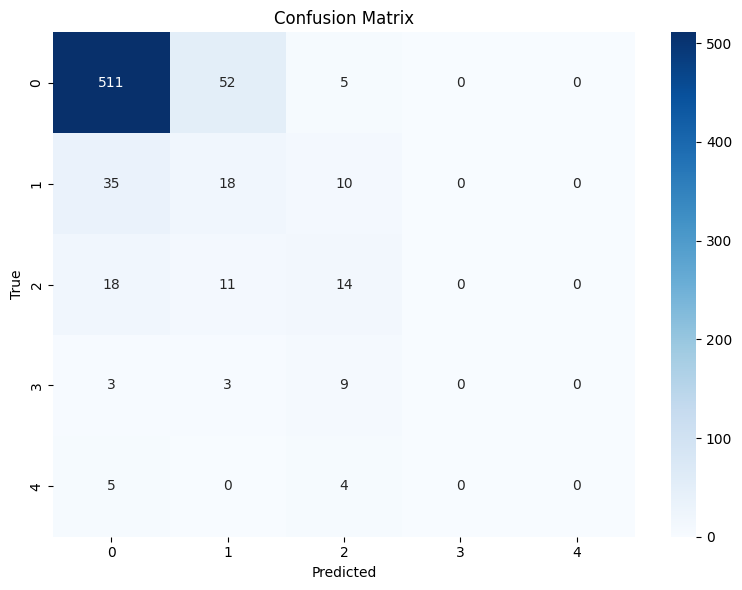


Test AUC (macro-average, OVR): 0.6906


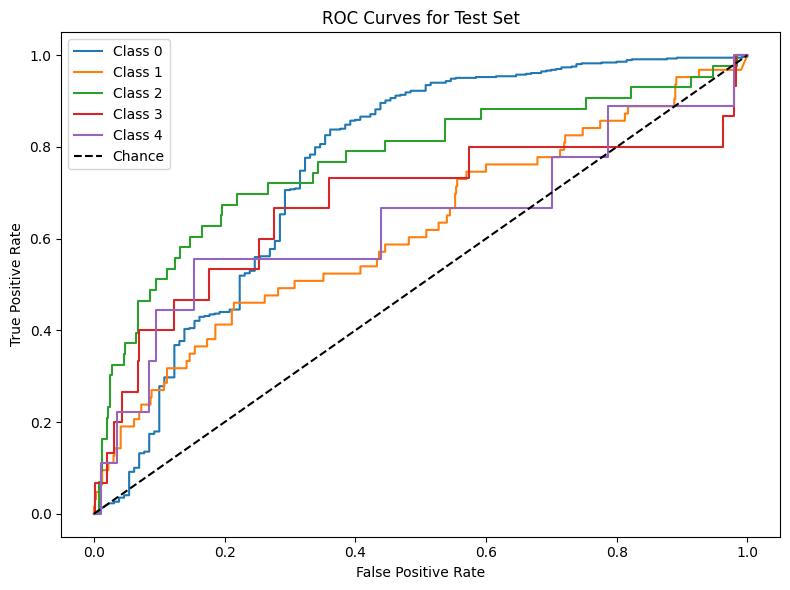

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.1


Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.95      0.92       544
           1       0.20      0.19      0.19        59
           2       0.39      0.29      0.33        42
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00         9

    accuracy                           0.81       668
   macro avg       0.30      0.28      0.29       668
weighted avg       0.77      0.81      0.79       668



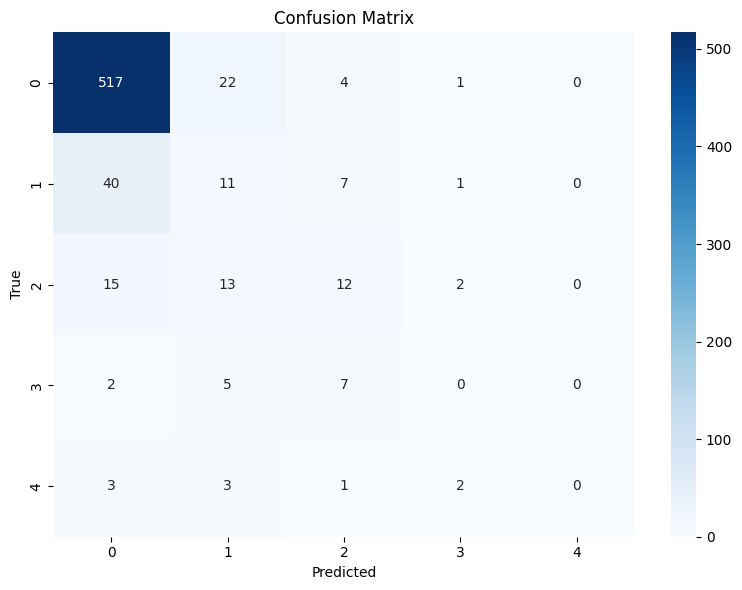


Test AUC (macro-average, OVR): 0.7066


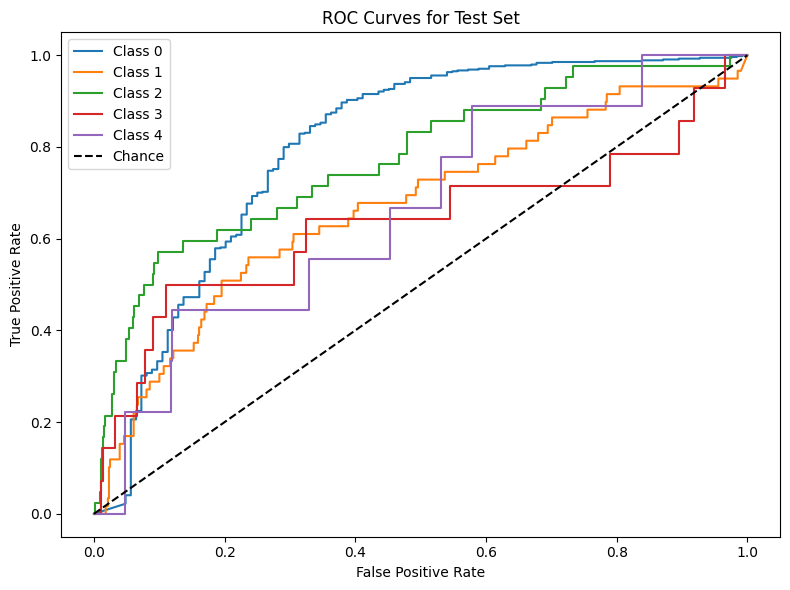

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(



Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.85      0.88       455
           1       0.24      0.46      0.32        52
           2       0.37      0.24      0.29        29
           3       0.33      0.10      0.15        10
           4       0.00      0.00      0.00         8

    accuracy                           0.76       554
   macro avg       0.37      0.33      0.33       554
weighted avg       0.79      0.76      0.77       554



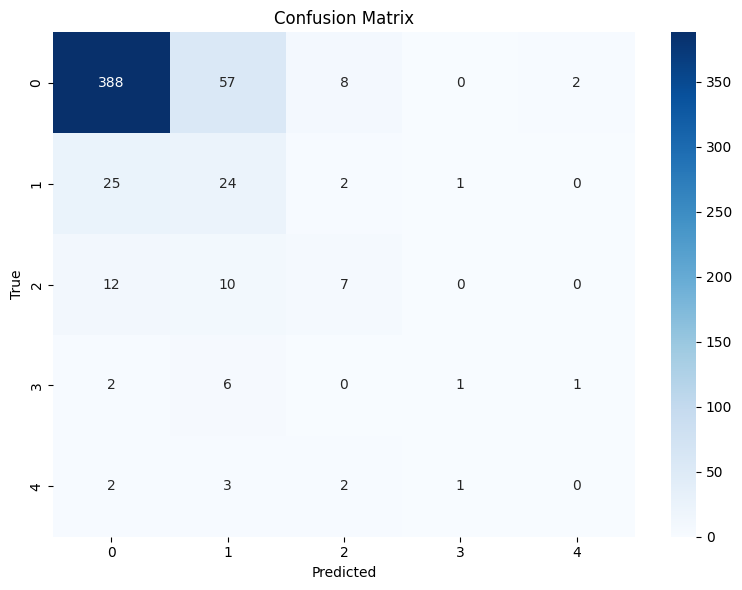


Test AUC (macro-average, OVR): 0.7228


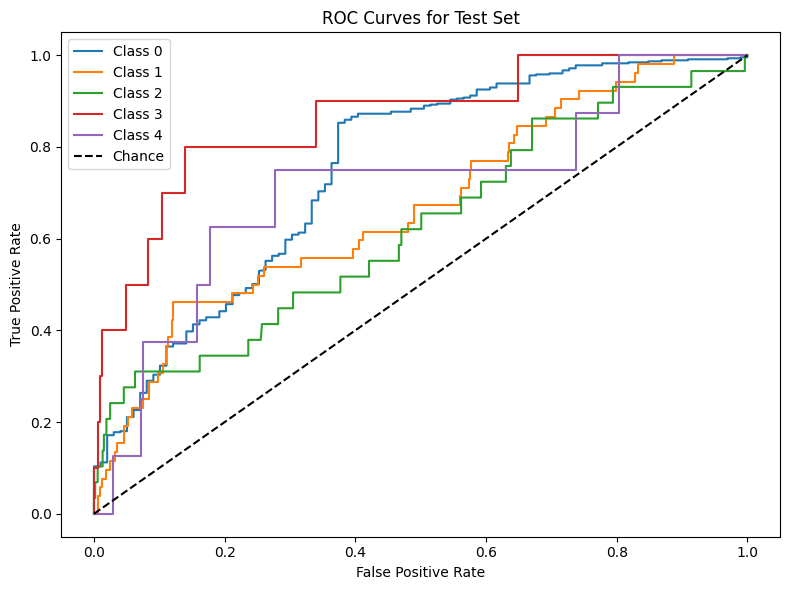

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(



Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       395
           1       0.28      0.35      0.31        40
           2       0.17      0.25      0.20        24
           3       0.33      0.10      0.15        10
           4       0.00      0.00      0.00         8

    accuracy                           0.79       477
   macro avg       0.34      0.32      0.31       477
weighted avg       0.80      0.79      0.79       477



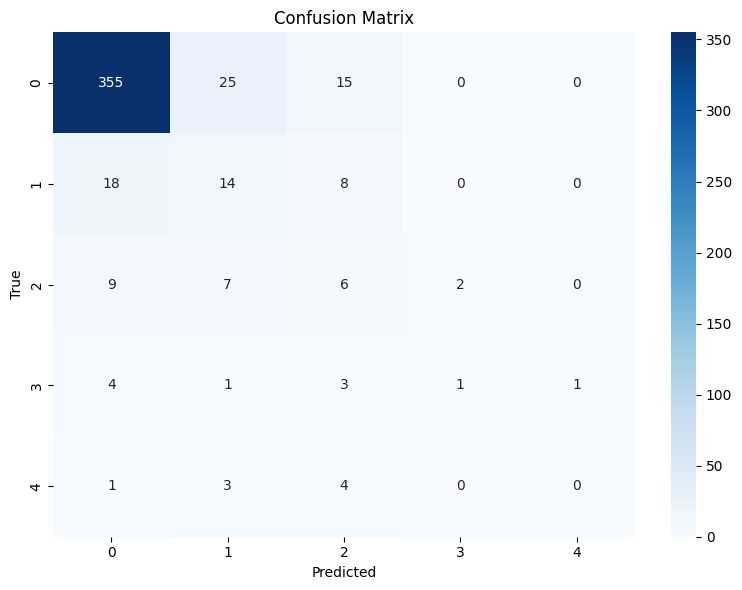


Test AUC (macro-average, OVR): 0.7603


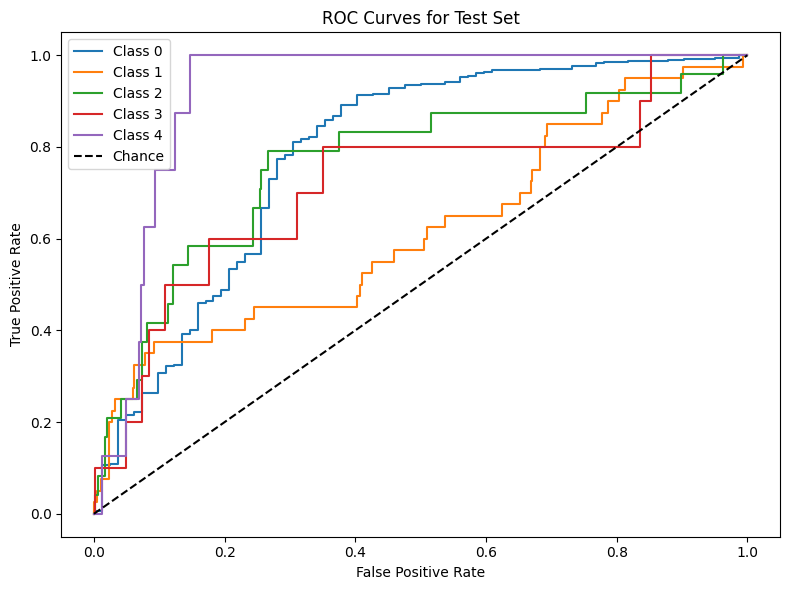

In [7]:
import glob

for i in range(1, 5):
    test_dir = f'/kaggle/input/enrich-data-node-clustering/phase{i}/user_train_phase_{i}_test.csv'
    
    # Get model and scaler using glob
    model_path = f'/kaggle/working/best_model_{temp}_phase{i}.pkl'
    scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
    # School mapping path
    school_mapping_file = f'/kaggle/input/smotesvm-train-enrich-data/outputs/phase{i}/mappings/school_mapping.pkl'

    # Predict on test set
    predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)


# Sample


=== Training Phase 1 ===
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

[Fold 1] Best Parameters Found: {'solver': 'adam', 'max_iter': 300, 'learning_rate_init': 0.01, 'hidden_layer_sizes': (100, 50), 'alpha': 0.0001, 'activation': 'logistic'}

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.61      0.72      1785
           1       0.40      0.56      0.46       604
           2       0.28      0.48      0.36       258
           3       0.19      0.53      0.27        59
           4       0.07      0.11      0.09         9

    accuracy                           0.58      2715
   macro avg       0.36      0.46      0.38      2715
weighted avg       0.69      0.58      0.62      2715



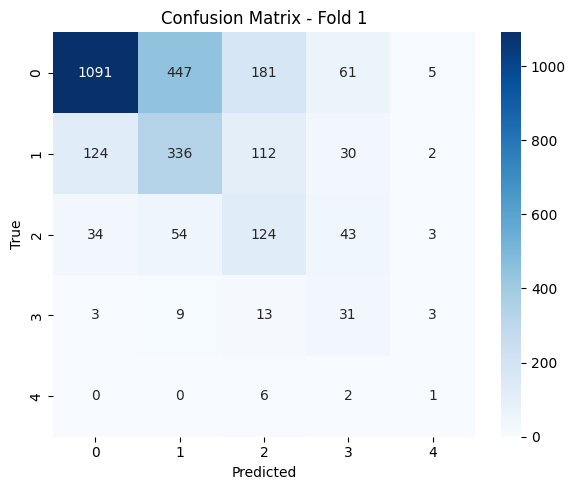

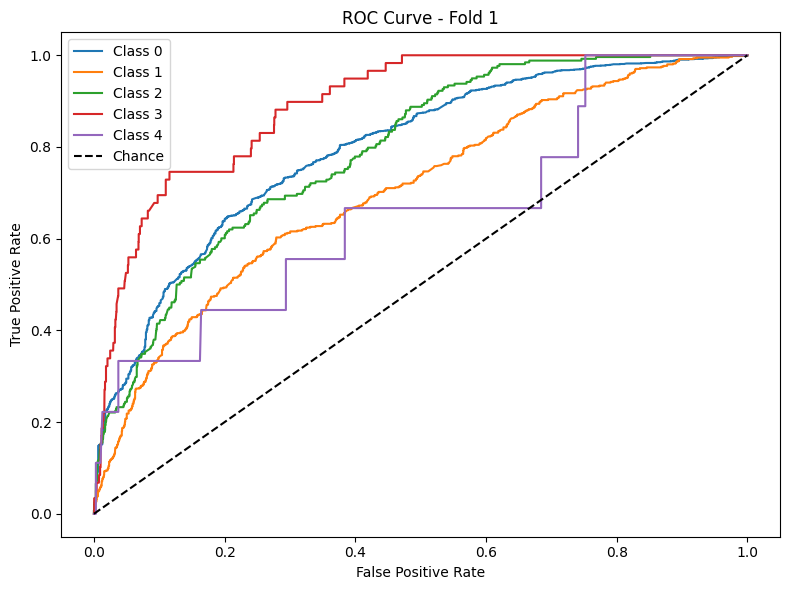


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.73      0.77      1786
           1       0.46      0.45      0.46       603
           2       0.38      0.44      0.41       258
           3       0.17      0.59      0.26        59
           4       0.09      0.25      0.13         8

    accuracy                           0.63      2714
   macro avg       0.38      0.49      0.41      2714
weighted avg       0.68      0.63      0.65      2714



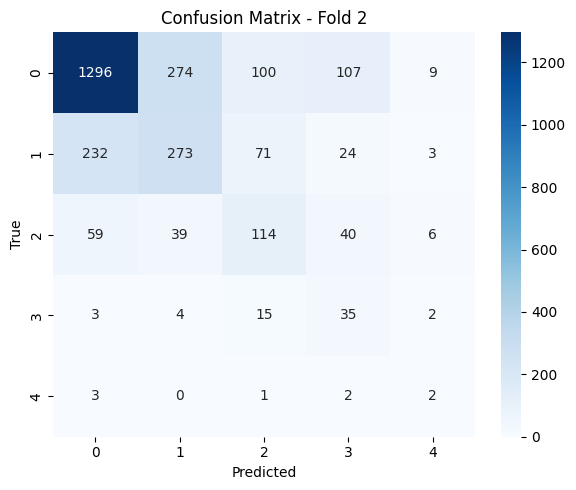

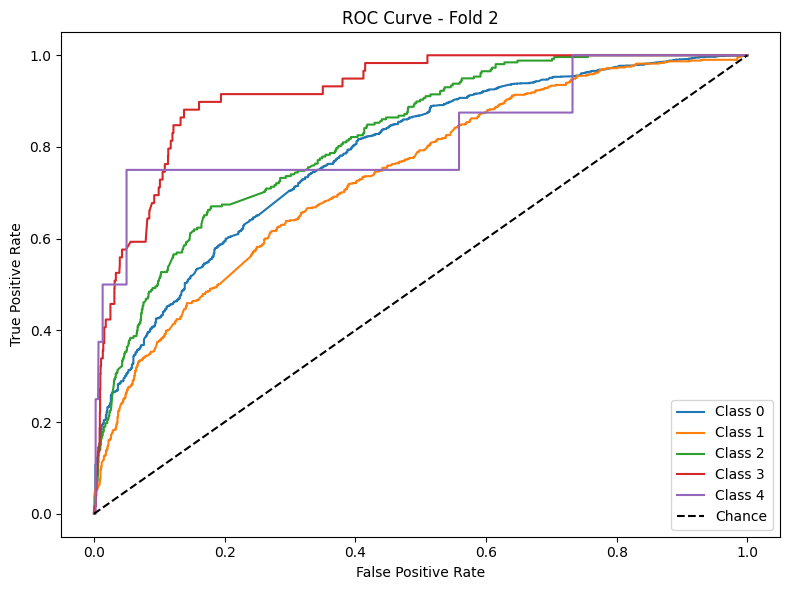


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.62      0.71      1786
           1       0.38      0.55      0.45       603
           2       0.34      0.51      0.40       258
           3       0.24      0.53      0.33        59
           4       0.13      0.25      0.17         8

    accuracy                           0.59      2714
   macro avg       0.39      0.49      0.41      2714
weighted avg       0.68      0.59      0.62      2714



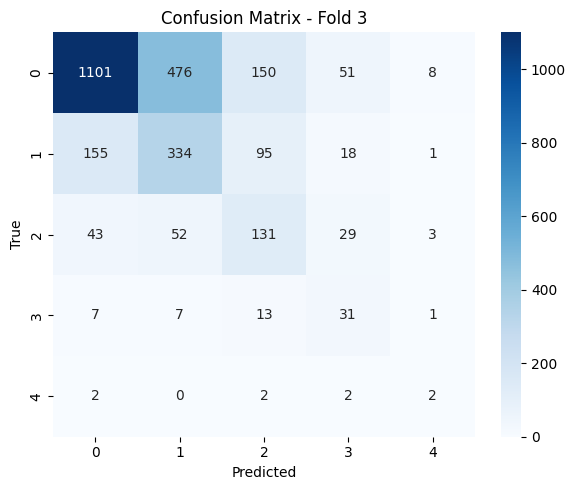

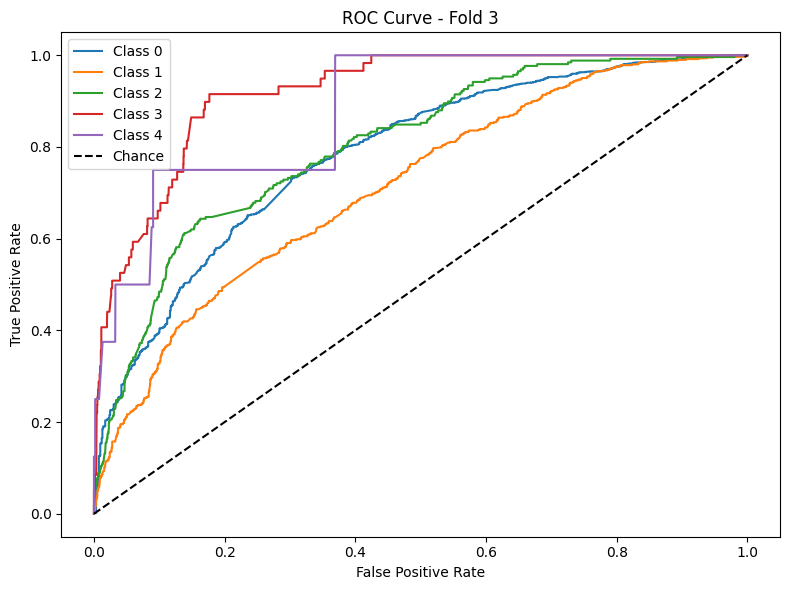


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.77      0.79      1785
           1       0.50      0.43      0.46       603
           2       0.36      0.52      0.43       258
           3       0.20      0.46      0.28        59
           4       0.12      0.11      0.12         9

    accuracy                           0.66      2714
   macro avg       0.40      0.46      0.42      2714
weighted avg       0.69      0.66      0.67      2714



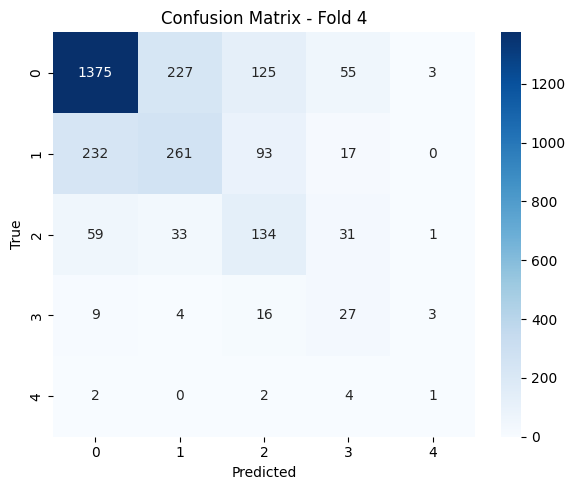

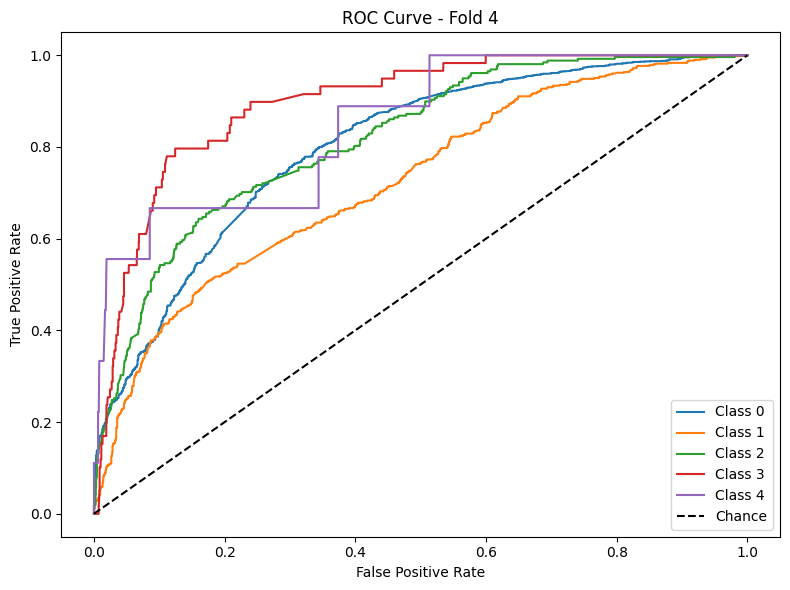


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.74      0.78      1785
           1       0.47      0.48      0.47       603
           2       0.39      0.44      0.41       258
           3       0.20      0.51      0.29        59
           4       0.15      0.67      0.24         9

    accuracy                           0.65      2714
   macro avg       0.41      0.57      0.44      2714
weighted avg       0.69      0.65      0.66      2714



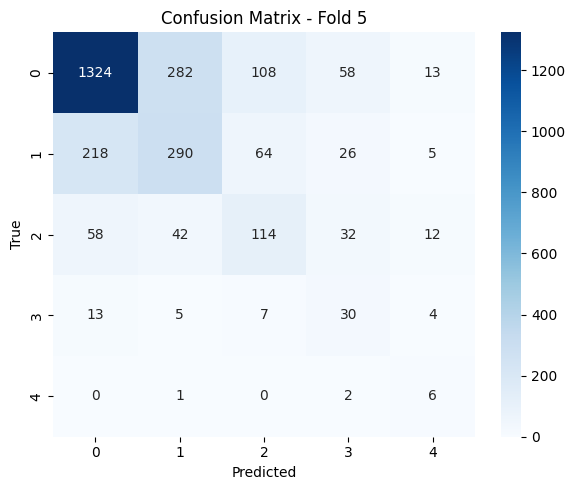

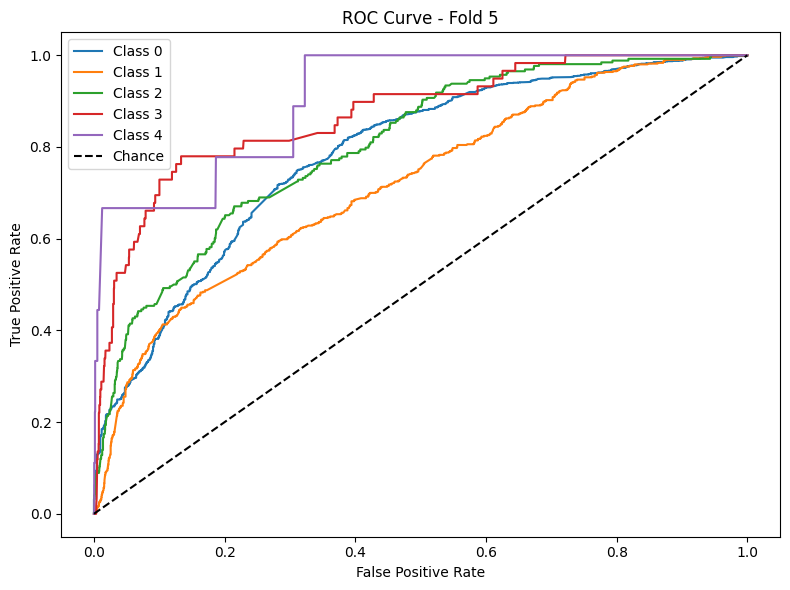


Average Accuracy: 0.6237
Average F1 Macro: 0.4113
Average AUC: 0.8076

=== Training Phase 2 ===
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

[Fold 1] Best Parameters Found: {'solver': 'adam', 'max_iter': 200, 'learning_rate_init': 0.001, 'hidden_layer_sizes': (50, 50), 'alpha': 0.0001, 'activation': 'relu'}


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.72      0.77      1489
           1       0.43      0.42      0.42       488
           2       0.31      0.48      0.38       220
           3       0.21      0.54      0.30        54
           4       0.29      0.22      0.25         9

    accuracy                           0.63      2260
   macro avg       0.41      0.48      0.43      2260
weighted avg       0.68      0.63      0.64      2260



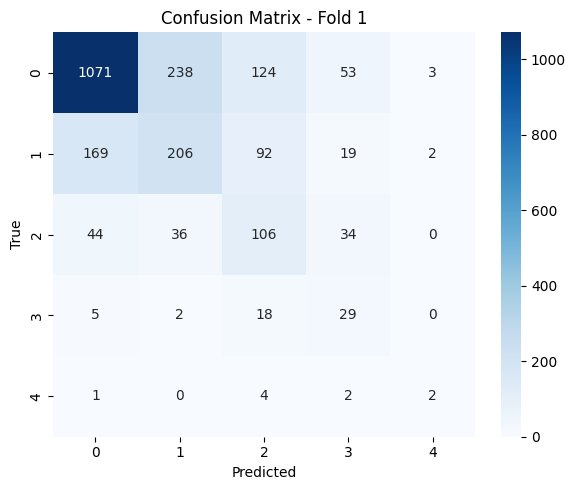

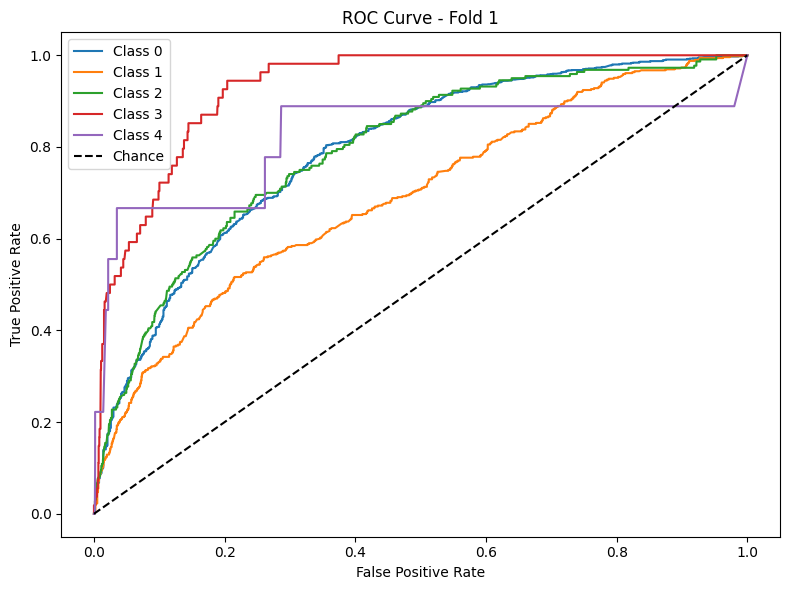

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.72      0.77      1489
           1       0.44      0.46      0.45       489
           2       0.33      0.44      0.38       219
           3       0.20      0.60      0.31        55
           4       0.25      0.38      0.30         8

    accuracy                           0.63      2260
   macro avg       0.41      0.52      0.44      2260
weighted avg       0.68      0.63      0.65      2260



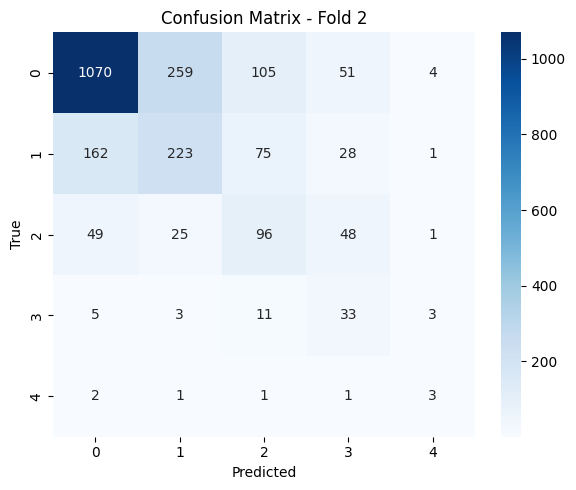

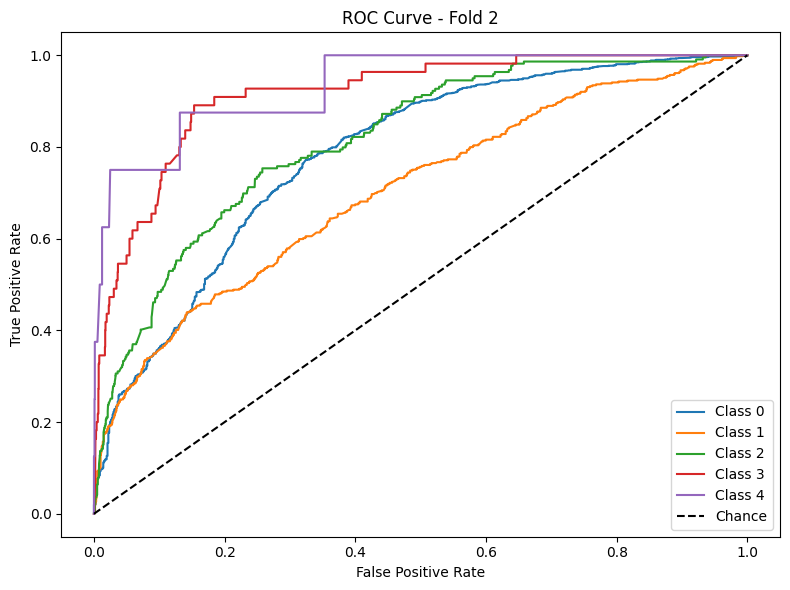

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.74      0.78      1489
           1       0.46      0.42      0.43       489
           2       0.36      0.52      0.43       219
           3       0.18      0.41      0.25        54
           4       0.27      0.50      0.35         8

    accuracy                           0.64      2259
   macro avg       0.42      0.52      0.45      2259
weighted avg       0.67      0.64      0.65      2259



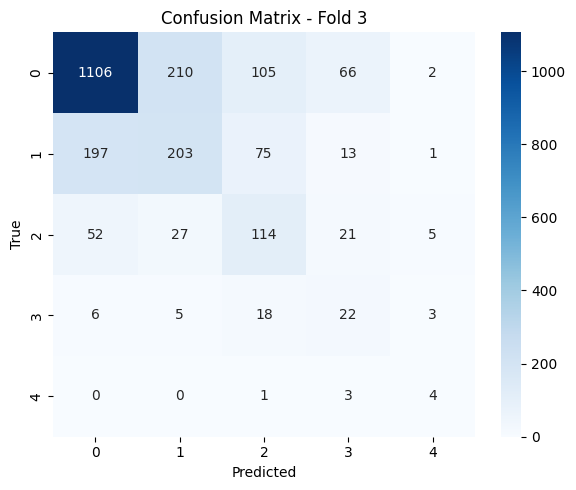

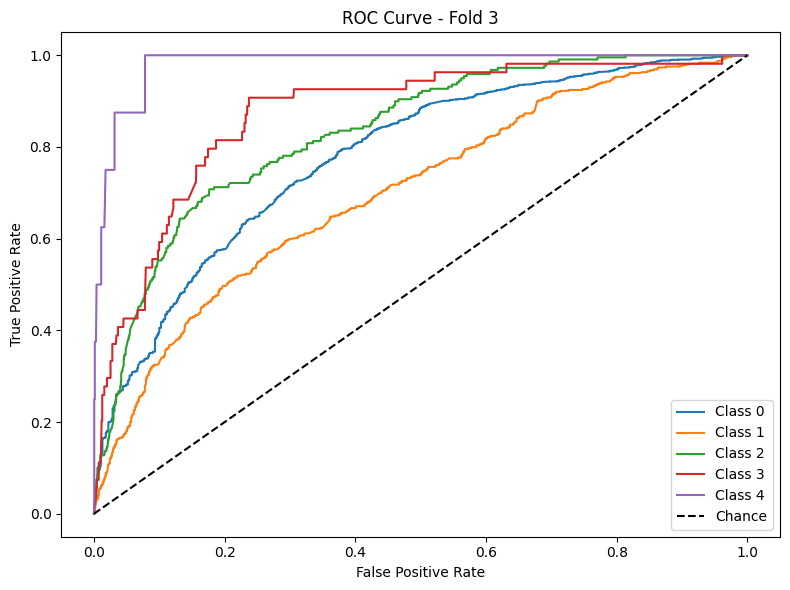

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.73      0.77      1489
           1       0.46      0.45      0.46       489
           2       0.38      0.55      0.45       219
           3       0.26      0.61      0.36        54
           4       0.20      0.25      0.22         8

    accuracy                           0.65      2259
   macro avg       0.42      0.52      0.45      2259
weighted avg       0.68      0.65      0.66      2259



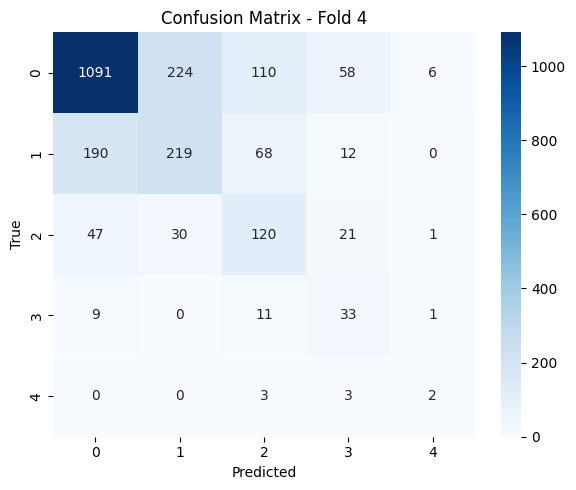

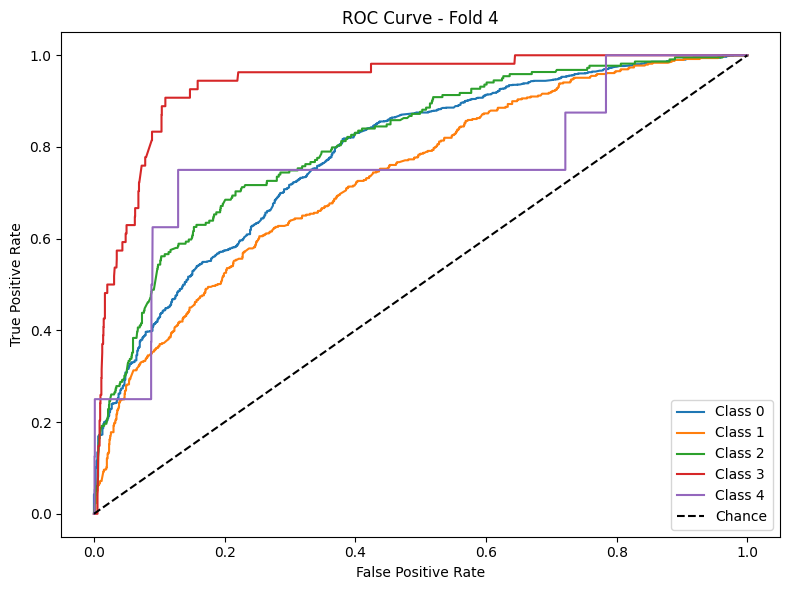


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.72      0.77      1490
           1       0.42      0.43      0.43       488
           2       0.37      0.54      0.44       219
           3       0.15      0.31      0.20        54
           4       0.13      0.25      0.17         8

    accuracy                           0.63      2259
   macro avg       0.38      0.45      0.40      2259
weighted avg       0.68      0.63      0.65      2259



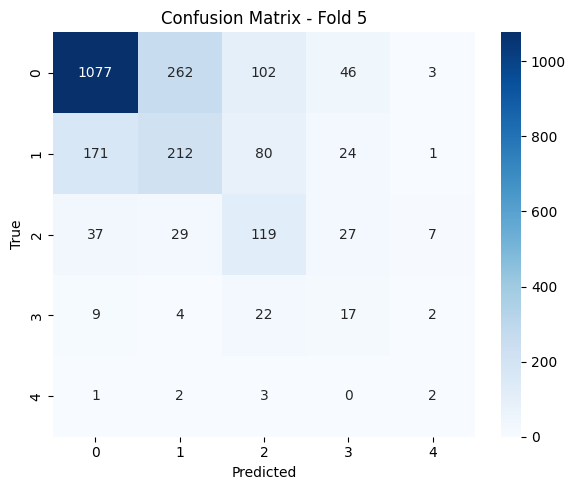

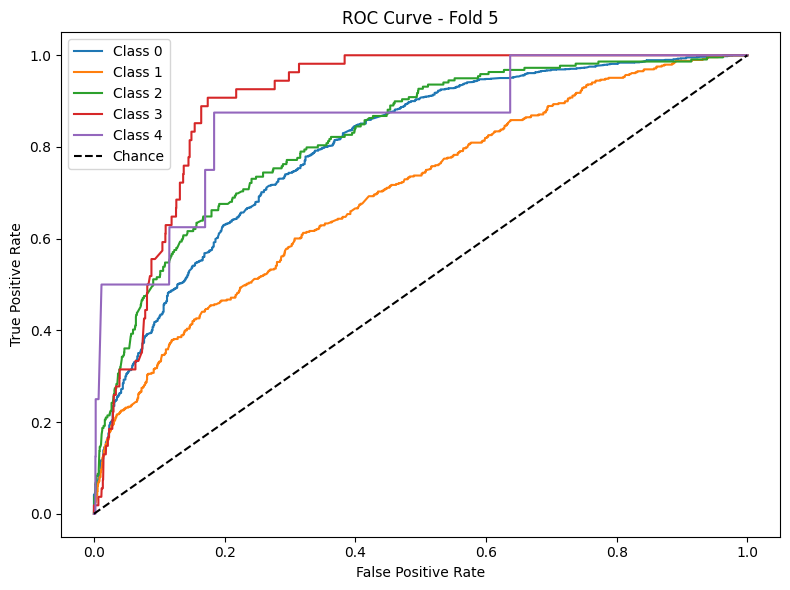


Average Accuracy: 0.6356
Average F1 Macro: 0.4335
Average AUC: 0.8181

=== Training Phase 3 ===
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Fold 1] Best Parameters Found: {'solver': 'adam', 'max_iter': 200, 'learning_rate_init': 0.001, 'hidden_layer_sizes': (50, 50), 'alpha': 0.01, 'activation': 'relu'}

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.75      0.80      1361
           1       0.46      0.47      0.47       459
           2       0.36      0.49      0.42       198
           3       0.25      0.51      0.34        49
           4       0.19      0.43      0.26         7

    accuracy                           0.66      2074
   macro avg       0.42      0.53      0.46      2074
weighted avg       0.70      0.66      0.67      2074



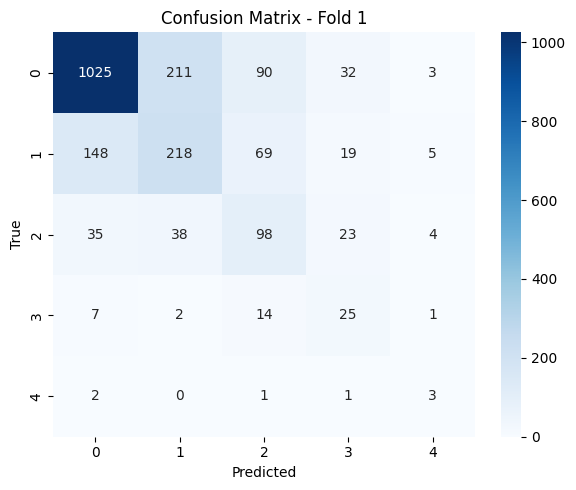

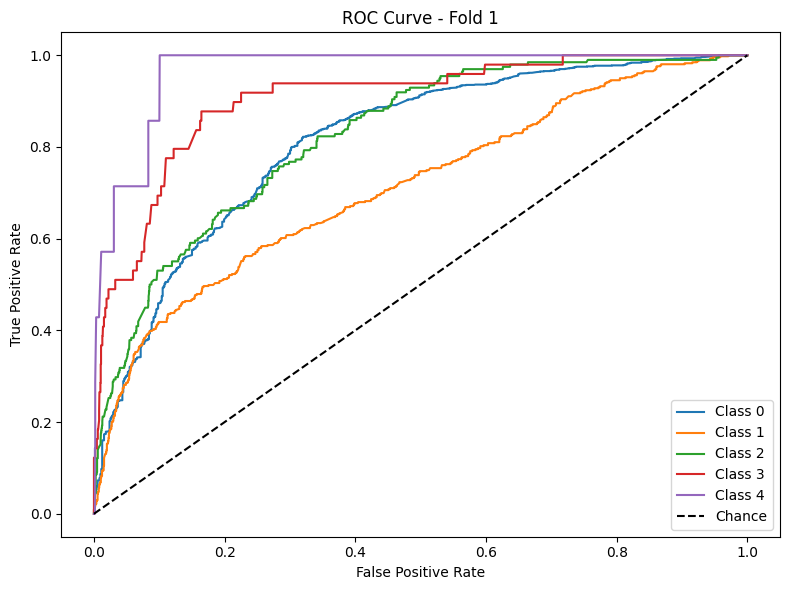


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.73      0.78      1360
           1       0.41      0.48      0.44       459
           2       0.36      0.44      0.39       198
           3       0.25      0.48      0.33        50
           4       0.11      0.29      0.16         7

    accuracy                           0.64      2074
   macro avg       0.39      0.48      0.42      2074
weighted avg       0.68      0.64      0.65      2074



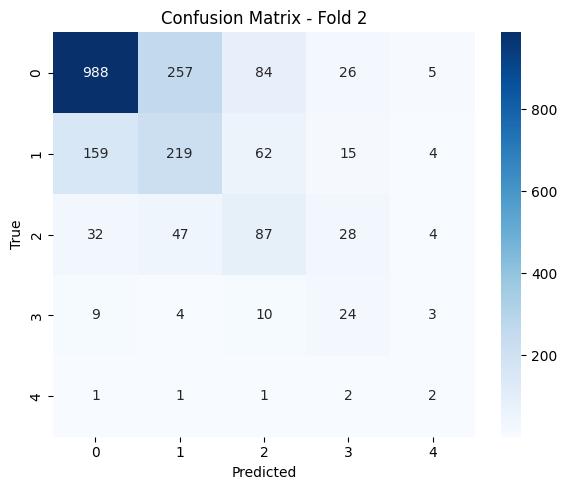

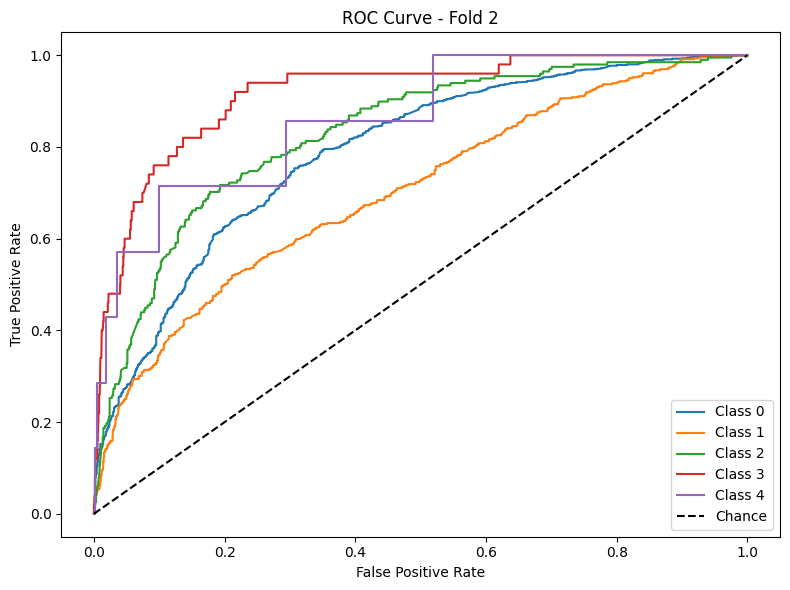

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.70      0.75      1360
           1       0.40      0.45      0.43       459
           2       0.35      0.46      0.40       198
           3       0.17      0.42      0.24        50
           4       0.13      0.43      0.20         7

    accuracy                           0.61      2074
   macro avg       0.38      0.49      0.40      2074
weighted avg       0.66      0.61      0.63      2074



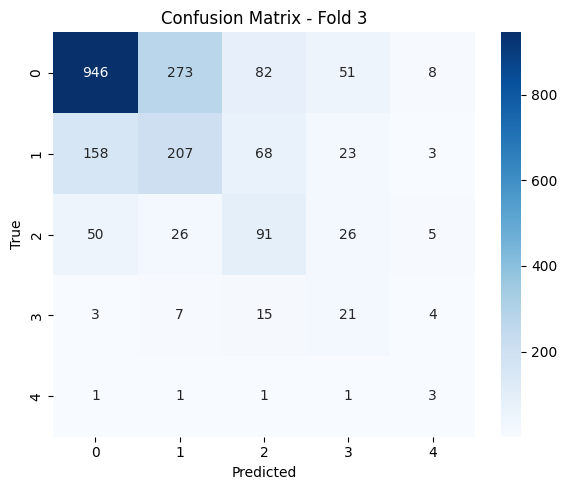

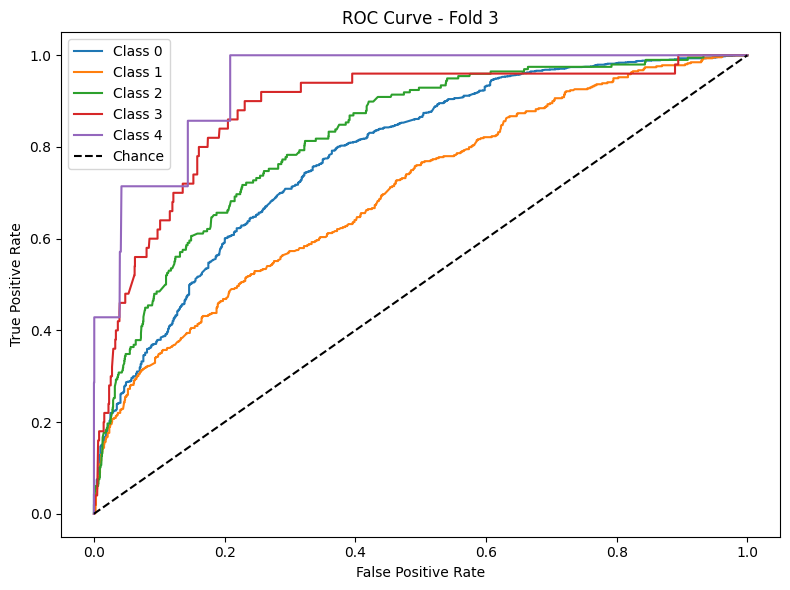

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.71      0.76      1360
           1       0.42      0.46      0.44       459
           2       0.36      0.46      0.41       198
           3       0.19      0.46      0.27        50
           4       0.00      0.00      0.00         7

    accuracy                           0.63      2074
   macro avg       0.36      0.42      0.38      2074
weighted avg       0.67      0.63      0.64      2074



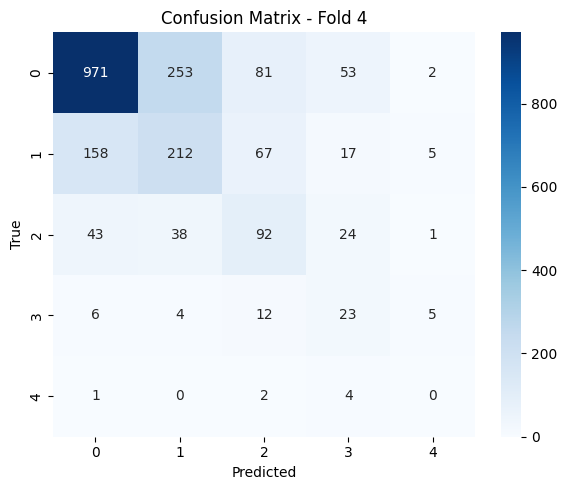

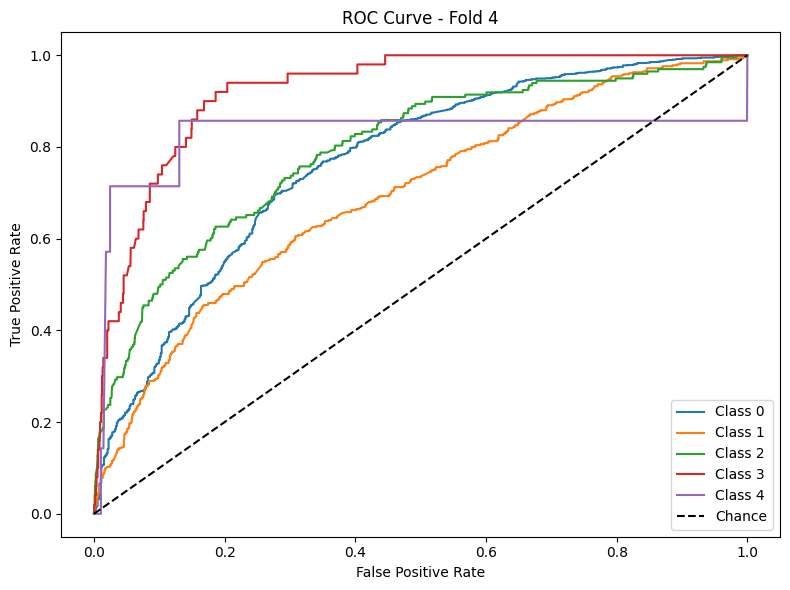

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.73      0.78      1360
           1       0.46      0.49      0.47       460
           2       0.37      0.50      0.42       197
           3       0.23      0.47      0.30        49
           4       0.14      0.14      0.14         7

    accuracy                           0.65      2073
   macro avg       0.40      0.47      0.42      2073
weighted avg       0.68      0.65      0.66      2073



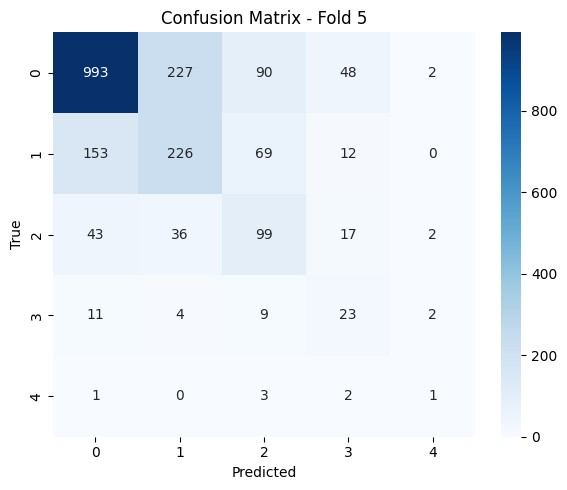

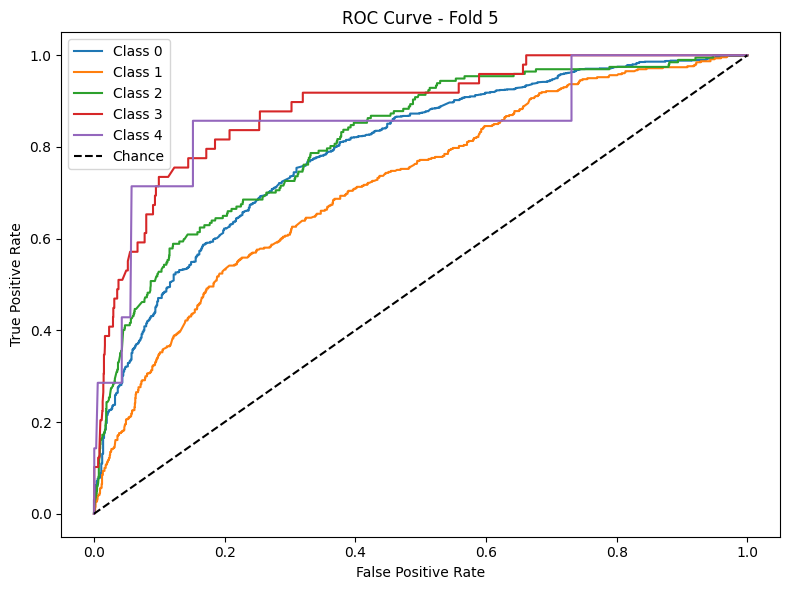


Average Accuracy: 0.6362
Average F1 Macro: 0.4162
Average AUC: 0.8206

=== Training Phase 4 ===
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

[Fold 1] Best Parameters Found: {'solver': 'adam', 'max_iter': 300, 'learning_rate_init': 0.001, 'hidden_layer_sizes': (100, 50), 'alpha': 0.001, 'activation': 'relu'}

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.73      0.77      1000
           1       0.46      0.49      0.48       355
           2       0.29      0.40      0.34       139
           3       0.25      0.44      0.32        39
           4       0.24      0.67      0.35         6

    accuracy                           0.64      1539
   macro avg       0.41      0.55      0.45      1539
weighted avg       0.67      0.64      0.65      1539



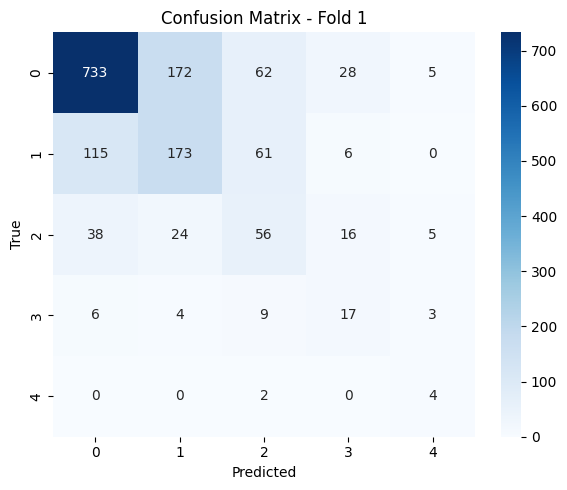

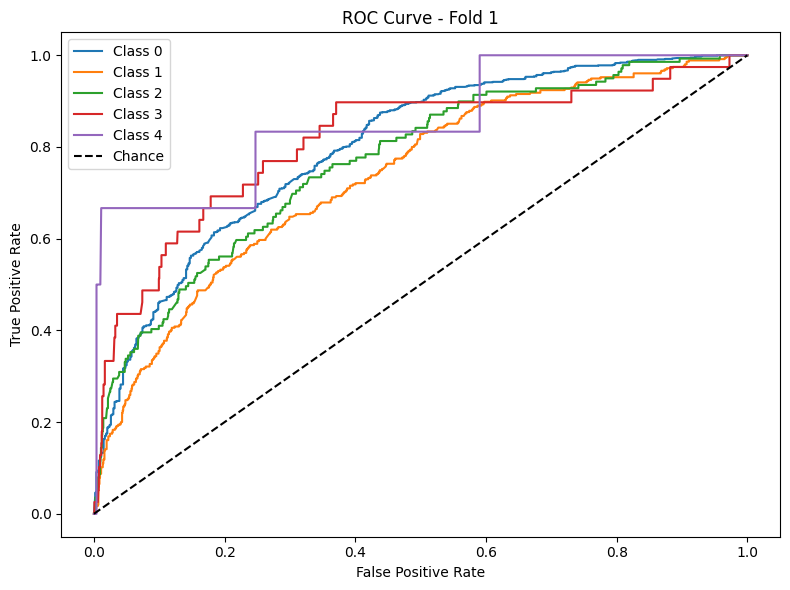


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.73      0.78      1000
           1       0.47      0.51      0.49       355
           2       0.42      0.50      0.46       139
           3       0.25      0.53      0.34        40
           4       0.11      0.40      0.17         5

    accuracy                           0.65      1539
   macro avg       0.42      0.53      0.45      1539
weighted avg       0.69      0.65      0.67      1539



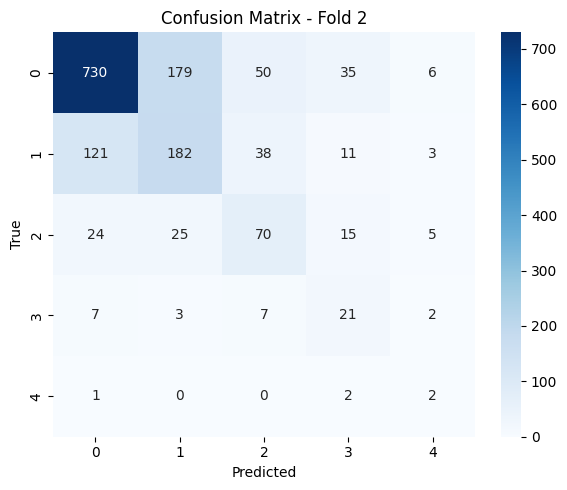

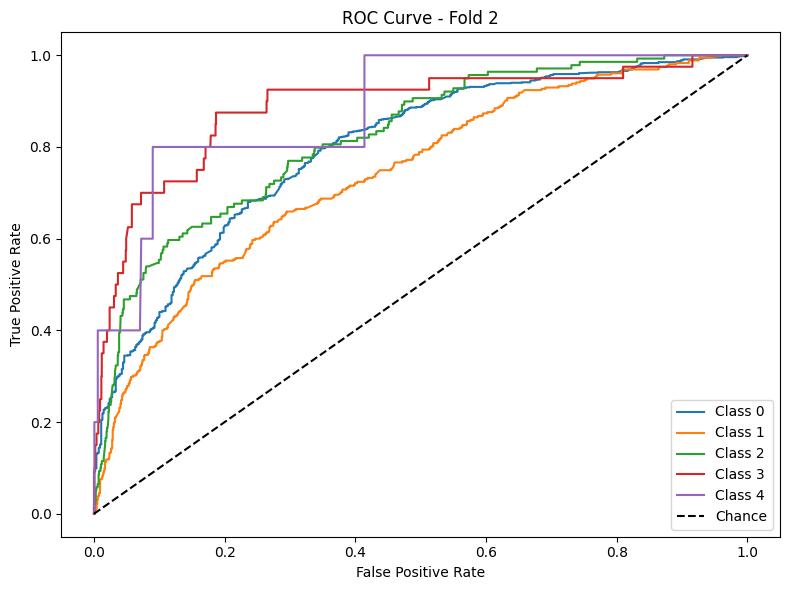


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.72      0.77       999
           1       0.46      0.52      0.49       355
           2       0.39      0.42      0.40       139
           3       0.22      0.57      0.32        40
           4       0.20      0.17      0.18         6

    accuracy                           0.64      1539
   macro avg       0.42      0.48      0.43      1539
weighted avg       0.68      0.64      0.66      1539



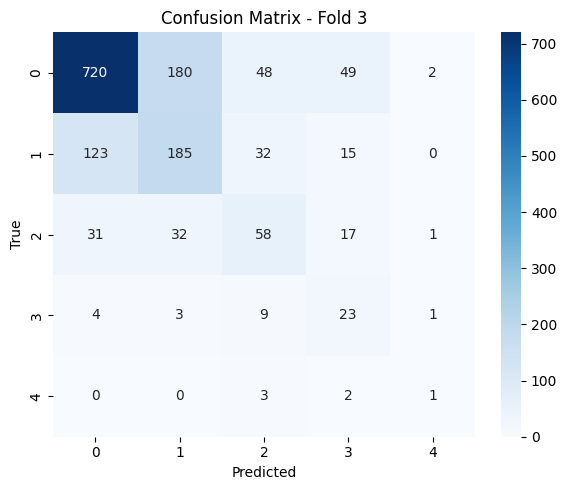

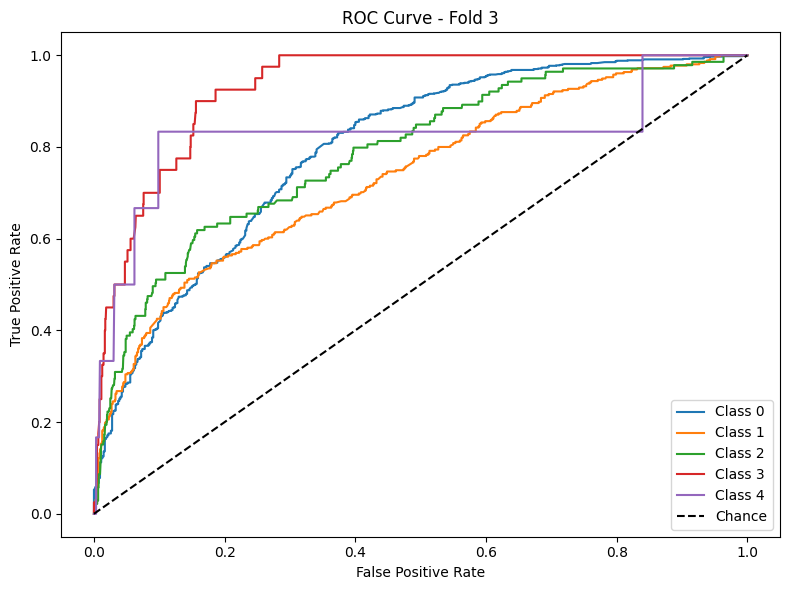


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.79      0.80       999
           1       0.46      0.42      0.44       356
           2       0.36      0.39      0.37       138
           3       0.26      0.49      0.34        39
           4       0.23      0.50      0.32         6

    accuracy                           0.66      1538
   macro avg       0.42      0.52      0.45      1538
weighted avg       0.67      0.66      0.66      1538



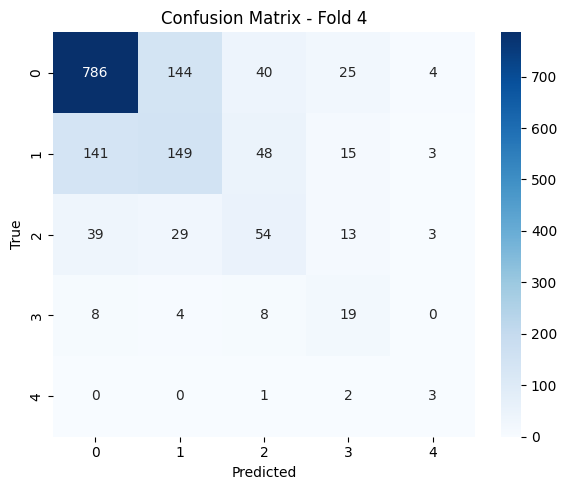

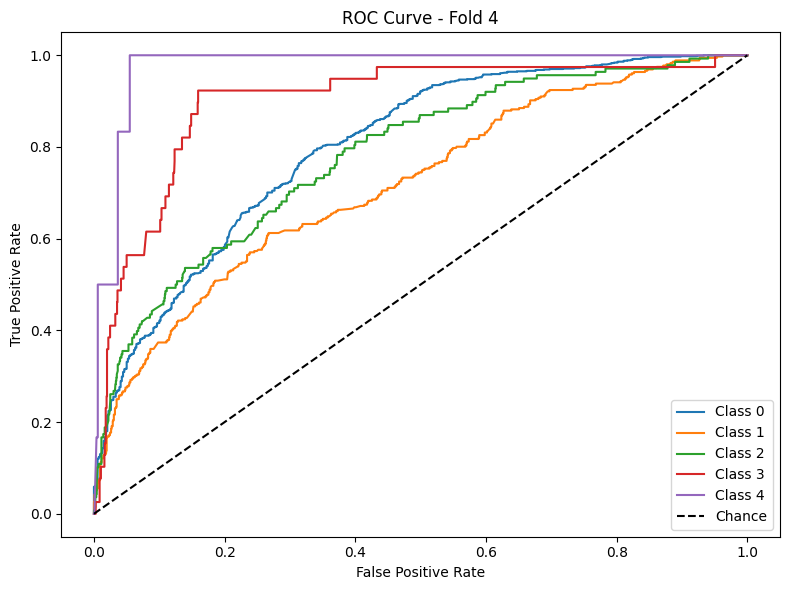


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.73      0.78       999
           1       0.47      0.54      0.51       356
           2       0.35      0.43      0.38       138
           3       0.29      0.56      0.38        39
           4       0.10      0.17      0.12         6

    accuracy                           0.65      1538
   macro avg       0.41      0.49      0.44      1538
weighted avg       0.69      0.65      0.67      1538



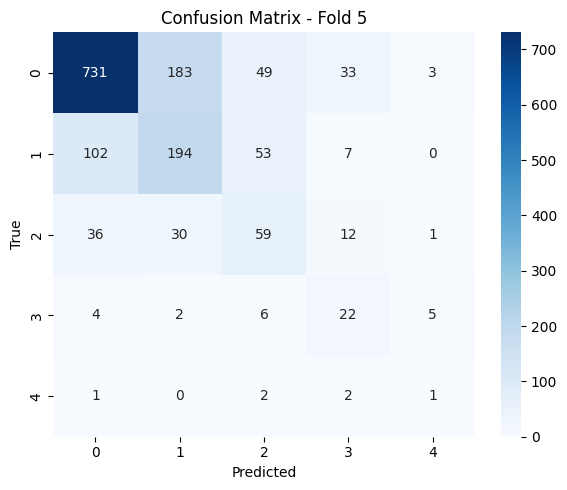

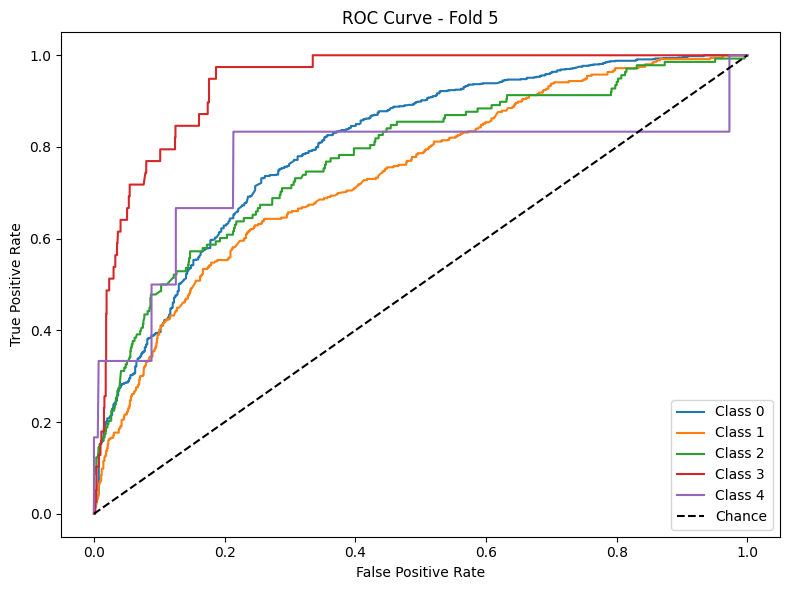


Average Accuracy: 0.6490
Average F1 Macro: 0.4437
Average AUC: 0.8153


In [8]:
phase_paths = [f"/kaggle/input/smotesvm-train-enrich-data/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n=== Training Phase {i} ===")
    sample = True
    model, scaler, best_fold, metrics = train_phase(phase_path, sample = sample)
    # Save best model & scaler
    if sample: 
        temp = "sample"
    else: temp = "no_sample"
    joblib.dump(model, f"best_model_{temp}_phase{i}.pkl")
    joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")
    results[f"phase{i}"] = metrics



Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.76      0.83       568
           1       0.14      0.38      0.21        63
           2       0.26      0.28      0.27        43
           3       0.50      0.07      0.12        15
           4       0.00      0.00      0.00         9

    accuracy                           0.67       698
   macro avg       0.36      0.30      0.28       698
weighted avg       0.78      0.67      0.71       698



/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


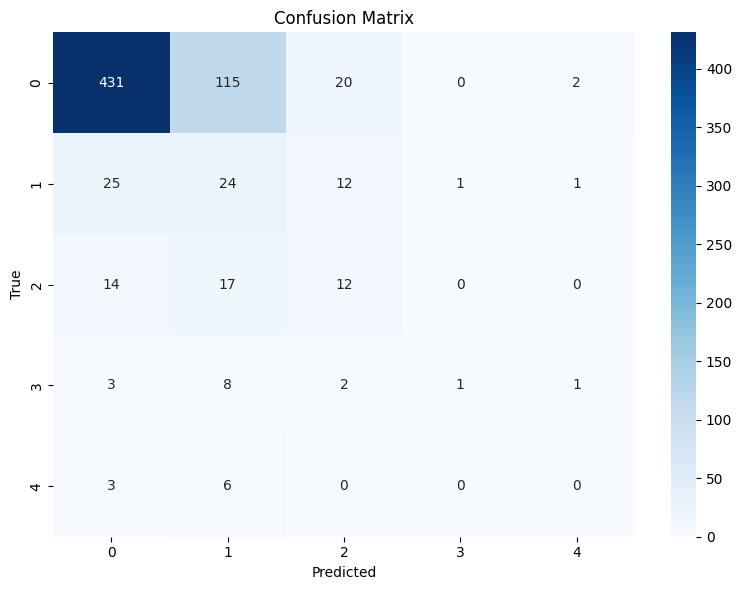


Test AUC (macro-average, OVR): 0.6522


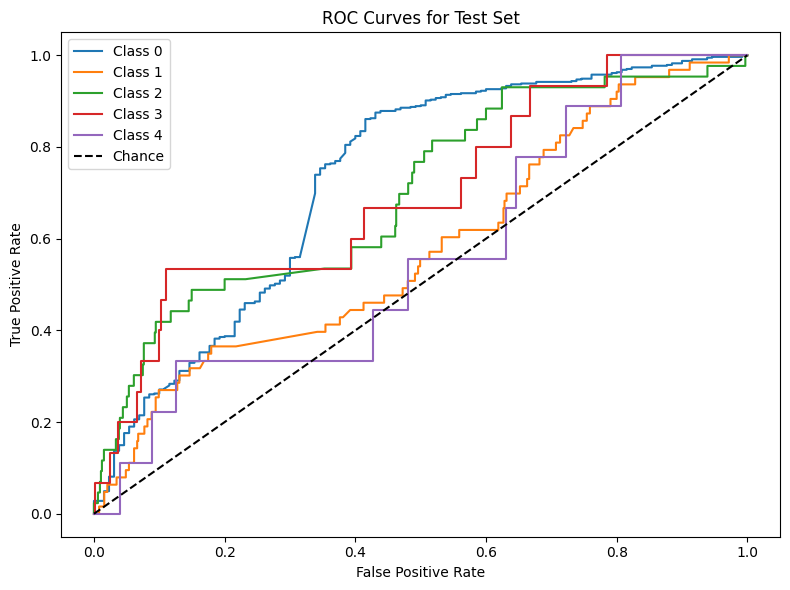

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(



Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.87      0.87       544
           1       0.23      0.37      0.28        59
           2       0.09      0.07      0.08        42
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00         9

    accuracy                           0.74       668
   macro avg       0.24      0.26      0.25       668
weighted avg       0.74      0.74      0.74       668



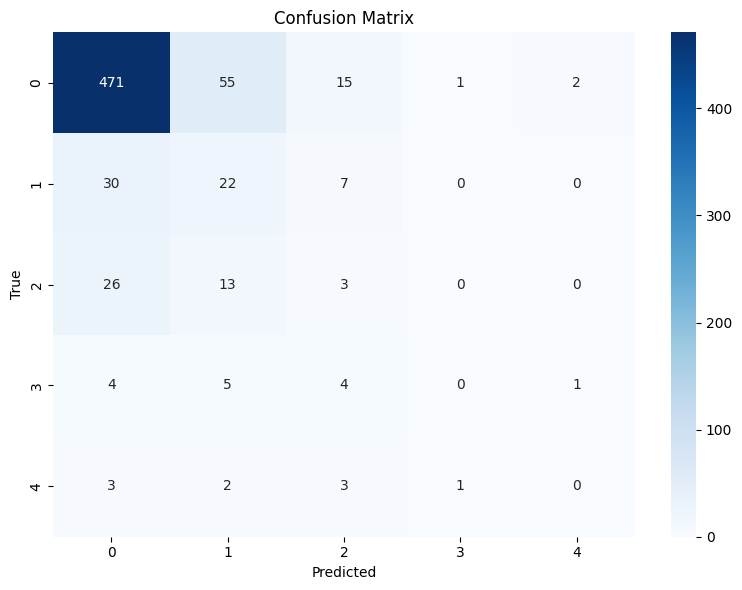


Test AUC (macro-average, OVR): 0.6236


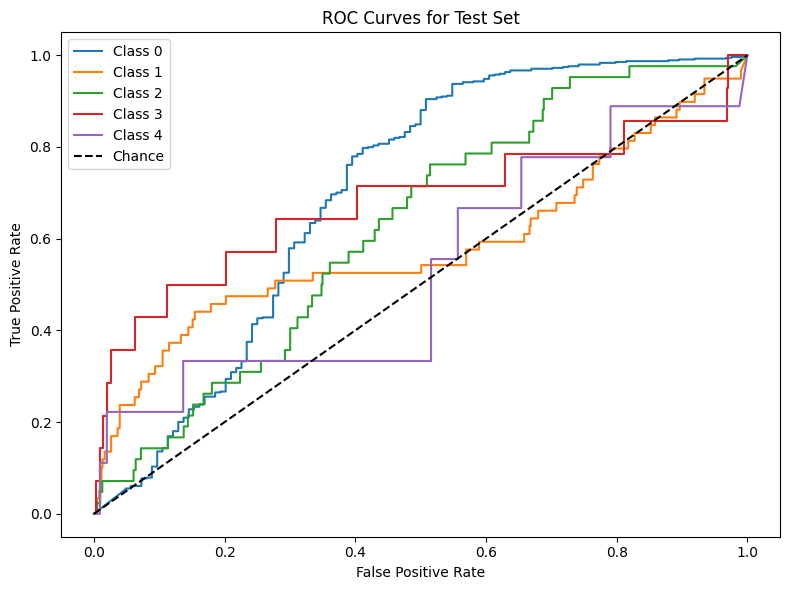

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(



Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.69      0.78       455
           1       0.13      0.42      0.20        52
           2       0.21      0.21      0.21        29
           3       0.09      0.10      0.10        10
           4       0.00      0.00      0.00         8

    accuracy                           0.62       554
   macro avg       0.27      0.28      0.26       554
weighted avg       0.77      0.62      0.68       554



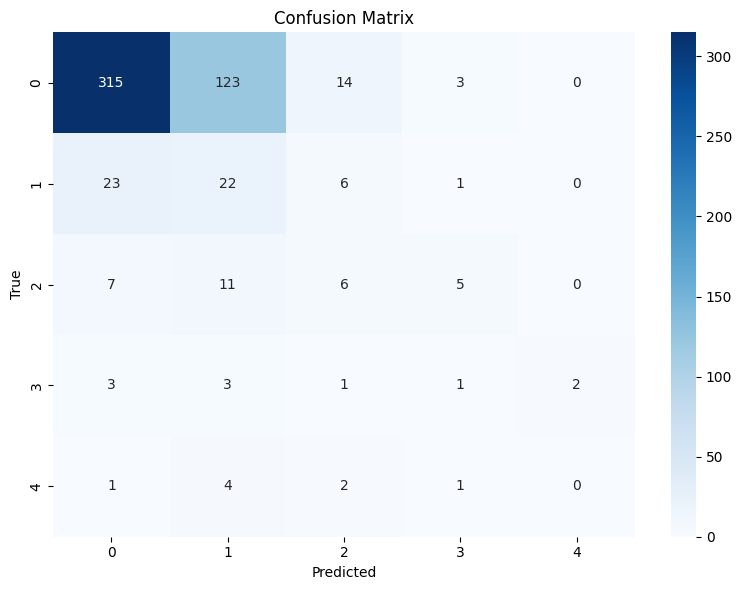


Test AUC (macro-average, OVR): 0.6185


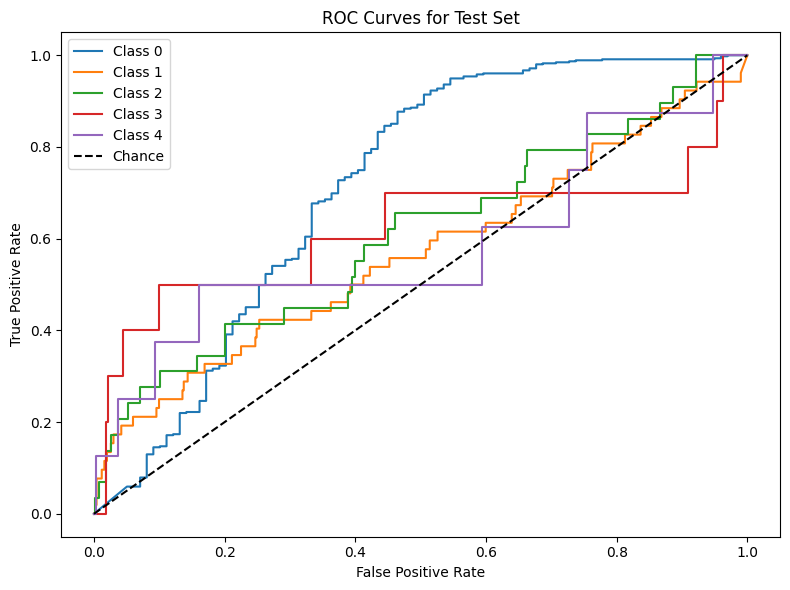

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(



Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.81      0.85       395
           1       0.08      0.12      0.10        40
           2       0.15      0.17      0.16        24
           3       0.03      0.10      0.05        10
           4       0.00      0.00      0.00         8

    accuracy                           0.69       477
   macro avg       0.23      0.24      0.23       477
weighted avg       0.76      0.69      0.72       477



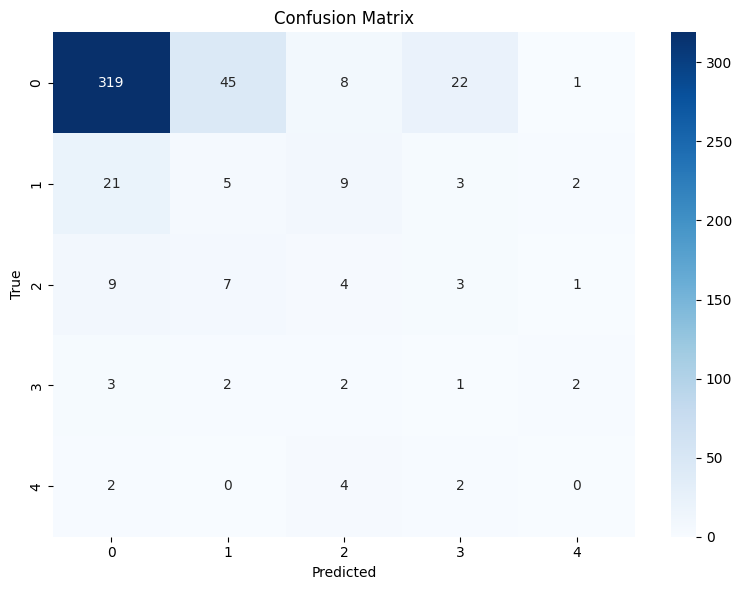


Test AUC (macro-average, OVR): 0.5855


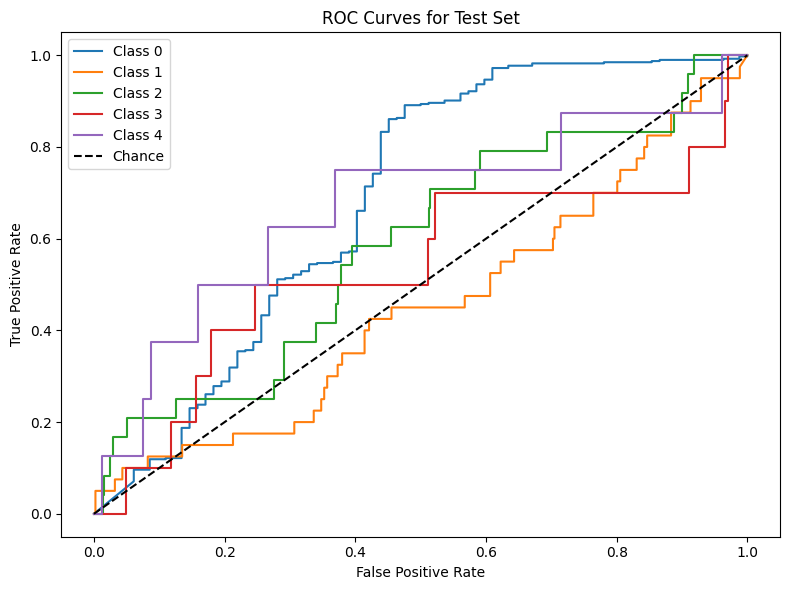

In [9]:
import glob

for i in range(1, 5):
    test_dir = f'/kaggle/input/enrich-data-node-clustering/phase{i}/user_train_phase_{i}_test.csv'
    
    # Get model and scaler using glob
    model_path = f'/kaggle/working/best_model_{temp}_phase{i}.pkl'
    scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
    # School mapping path
    school_mapping_file = f'/kaggle/input/smotesvm-train-enrich-data/outputs/phase{i}/mappings/school_mapping.pkl'

    # Predict on test set
    predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)
